# Model Training & Evaluation

## Project Context and Objective

The goal of this project is to train and evaluate a binary classification model capable of analyzing source code commit metadata and determine if the commit represented a bugfix or if it was not indicative of a bugfix commit.

The value of such a model is that it can analyze historical commits in any git repository and flag commits that are likely bugfix commits. This allows us to isolate patterns in time (periods of higher or lower than average bugfix activity) and space (areas of code significantly more or less likely to encounter bugfix commits).

The data source for this training effort primarily came from a tool called **GitStractor** I've been developing. GitStractor is a .NET utility that works with LibGit for git analysis and uses the results of git analysis to generate CSV data files for visualization and for model training.

Data in those CSV files was then labelled via a Phi-3 LLM running on-device and then reviewed and corrected by myself based on my knowledge of the source code and its history.

## Evaluation Criterion

The primary metric used to evaluate models was the F1 Score in order to select a generally accurate model that performed well with positive and negative classes. Given two models of roughly comparable F1 Scores, my secondary metric was the positive precision of the model. Precision was chosen because a Type II error where we predict a bugfix commit is a non-bugfix has minor impact on overall metrics and visualizations whereas a model that systemically makes more Type I errors could erroneously portray code in some areas of applications as far more buggy than it actually is, which could potentially have negative impacts in how teams or individuals are viewed.

An ideal model would allow for near instantaneous inferencing running inside of a .NET process. This would allow the model to be deployed alongside GitStractor and be used to classify commits during data extraction. This sets a general preference for a ML.NET native model, though models trained in other frameworks and exported to ONNX then imported into ML.NET via ONNX could also be considered.

As a result, this notebook prefers ML.NET and operates in a Polyglot Notebook using C# and ML.NET for its model training. Additionally, I made liberal use of ML.NET AutoML for model trainer discovery, pipeline construction, and hyperparameter tuning once the best model trainers and pipeline steps were identified.

## About Polyglot Notebooks and this Notebook
This is a Polyglot Notebook intended to run on the .NET interactive kernel currently running on .NET 8.

This notebook's role is to build and evaluate model training pipelines, perform hyperparameter tuning, and find a series of best models for commit classification using ML.NET. Other model training efforts will be performed using Python in a separate notebook, but those efforts will focus on models that support ONNX export that can be imported into ML.NET. This is because the ultimate selected model will be integrated into GitStractor which runs on .NET and ML.NET is the best available vector to do that.

You can run this code locally with VS Code and .NET 8 installed, or you can create a GitHub CodeSpace at the project's GitHub repository at [https://github.com/IntegerMan/GitStractorCommitClassification](https://github.com/IntegerMan/GitStractorCommitClassification).

I have also included a PDF of the contents of this notebook for ease of evaluation.

## Additional Libraries

While ML.NET has been around for a number of years and Polyglot Notebooks is no longer brand new, these technologies do not necessarily work seamlessly together. As a result, I have created and published pre-alpha versions of 4 small utility libraries as part of this final capstone. These libraries are prefixed with `MattEland.ML` and are generally for charting, hyperparameter extraction, and model performance comparison. I also took advantage of this to hide code from this notebook that was not critical to model training and evaluation tasks.

The source code for these libraries is available on GitHub at [https://github.com/integerman/MattEland.ML](https://github.com/integerman/MattEland.ML).

## Notebook Notes

This notebook does take a significant amount of time to run as some of the experiments are oriented on determining what an ideal training time would be with AutoML while others involve the use of deep learning algorithms. Expect the notebook to take around a half hour to run, depending on your hardware. Again, output of the notebook is available in PDF format if the .ipynb file is not properly rendering the cached versions of Plotly.NET charts.

Finally, the notebook does reference the experiment results from `ModelTrainingPython.ipynb` where SciKit-Learn models were evaluated for comparison to ML.NET models and `TextClassification.ipynb` where a fine-tuning experiment was done on a Roberta model. That particular notebook is designed to run on Linux using CUDA 12, though with different dependencies it could run on other OSes, CUDA versions, or on CPU. The results of both efforts are included in this notebook and discussed briefly later on.

## Dependencies
With the preamble out of the way, it's time to install external dependencies into the notebook via NuGet packages, then import relevant namespaces.

In [1]:
#r "nuget:Microsoft.Data.Analysis"
#r "nuget:Microsoft.ML"
#r "nuget:Microsoft.ML.AutoML"
#r "nuget:Newtonsoft.Json"
#r "nuget:Plotly.NET"
#r "nuget:Plotly.NET.Interactive"

using Microsoft.DotNet.Interactive.Formatting;
using Microsoft.Data.Analysis;
using Microsoft.ML;
using Microsoft.ML.AutoML;
using Microsoft.ML.AutoML.CodeGen;
using Microsoft.ML.SearchSpace;
using Microsoft.ML.SearchSpace.Option;
using Microsoft.ML.Data;
using Microsoft.ML.Trainers;
using Microsoft.ML.Trainers.LightGbm;
using Microsoft.ML.Transforms;
using Microsoft.ML.Transforms.Text;
using Newtonsoft.Json;
using System.Reflection;

Installed Packages Microsoft.Data.Analysis, 0.21.1 Microsoft.ML, 3.0.1 Microsoft.ML.AutoML, 0.21.1 Newtonsoft.Json, 13.0.3 Plotly.NET, 5.0.0 Plotly.NET.Interactive, 5.0.0

Loading extensions from `/home/matteland/.nuget/packages/plotly.net.interactive/5.0.0/lib/netstandard2.1/Plotly.NET.Interactive.dll`

Loading extensions from `/home/matteland/.nuget/packages/microsoft.data.analysis/0.21.1/interactive-extensions/dotnet/Microsoft.Data.Analysis.Interactive.dll`

Loading extensions from `/home/matteland/.nuget/packages/microsoft.ml.automl/0.21.1/interactive-extensions/dotnet/Microsoft.ML.AutoML.Interactive.dll`

Loading extensions from `/home/matteland/.nuget/packages/skiasharp/2.88.6/interactive-extensions/dotnet/SkiaSharp.DotNet.Interactive.dll`

Note that there are 4 extensions for Polyglot Notebooks that also were registered as part of this process.

### Custom Library Dependencies

Next we'll import the custom libraries I authored for this project.

This makes things easier for model tracking, charting, etc. These were non-core to the analysis and were intended to benefit the community as a whole.

In fact, I hope to publish a more mature version of these to the global community this fall under a different name.

You can find these libraries and their code [on GitHub](https://github.com/IntegerMan/MattEland.ML)

In [2]:
#r "nuget:MattEland.ML"
#r "nuget:MattEland.ML.Charts"
#r "nuget:MattEland.ML.DataFrames"
#r "nuget:MattEland.ML.Interactive"

using MattEland.ML;
using MattEland.ML.Charts;
using MattEland.ML.DataFrames;
using MattEland.ML.Interactive;

reflect 
 This extension generates a list of properties on the object in tabular format.

transformer-vis 
 This extension generates Flowcharts from ITransformers using the Mermaid kernel.

pipeline-vis 
 This extension generates Flowcharts from Pipelines using the Mermaid kernel.

## Data Loading

With libraries ready, it's time to load up our training data. This dataset was created during the exploratory data analysis phase of the project and involved feature engineering and data cleaning at that point.

Specifically, a number of calculated columns were added to the dataset at that time. As a result, this notebook will not focus much on feature engineering, aside for that involved in text processing. We will get into normalization and imputing as the notebook goes on, though.

That said, let's load up our data.

In [4]:
var df = DataFrame.LoadCsv("data/Training.csv", separator: ',', header: true);
df.Sample(5)

index,PredictedLabel,ActualLabel,Message,Reasoning,Sha,Source,ParentSha,Parent2Sha,IsMerge,AuthorId,AuthorDateUtc,CommitterId,CommitterDateUtc,WorkItems,TotalFiles,ModifiedFiles,AddedFiles,DeletedFiles,TotalLines,NetLines,AddedLines,DeletedLines,HasAddedFiles,HasDeletedFiles,DayOfWeek,Month,Quarter,Year,Hour,TimeOfDay,IsWeekend,MessageLength,WordCount
0,True,True,us gc memory pressure,Memory pressure issues are typically related to bugs in code or resource management,ce5792095a7a883560c8ea96db7ef904d9c1c97b,dotnetinteractive,26f2ec8f10d74d98bba373cbe505b43b2c667243,,False,10,2020-07-01 13:16:49Z,14,2020-07-01 17:50:35Z,0,4,2,2,0,581,34,42,8,True,False,Wednesday,July,3,2020,13,Afternoon,False,21,4
1,False,False,Update description about key type and add one more reference (#3170),The commit message indicates updating documentation or code references rather than fixing a bug.,68640bb5099414dfcf375f3ede8b7bd6e549a93f,mlnet,a5f09772279b1f947072ff5ca28e27c76726e156,,False,66,2019-04-05 14:15:12Z,7,2019-04-05 18:15:12Z,1,1,1,0,0,569,-2,11,13,False,False,Friday,April,2,2019,14,Afternoon,False,68,11
2,True,False,Add SamplingKeyColumnName to AutoMLExperiment (#6649),Adding columns is typically for data preparation in ML processes which can relate to fixing bugs if the dataset previously lacked necessary features.,d974a212538884bbffa0d95c82bf85de44a55782,mlnet,ce9938d37951ca94e7e94d2dc4779fecf52d8f54,,False,209,2023-05-04 18:06:42Z,7,2023-05-04 22:06:42Z,1,4,4,0,0,1003,25,28,3,False,False,Thursday,May,2,2023,18,Afternoon,False,53,5
3,True,True,Temporarily remove parent-pid launch argument for Kusto,The action implies addressing an issue related to process management or environment configuration,45f0994a7a3a8d7982e3d36e08c154ca8fe5158c,dotnetinteractive,9123950d56f3f9f2d9f0cf1e8b943748abb62bff,,False,54,2023-01-17 19:34:48Z,6,2023-01-18 01:34:06Z,0,1,1,0,0,84,0,1,1,False,False,Tuesday,January,1,2023,19,Evening,False,55,7
4,False,False,[main] Update dependencies from dotnet/arcade (#6126),Updating dependencies typically relates to maintenance rather than fixing a bug.,0f649910af439a7acb5142c811b366d9b6acd630,mlnet,23c45aab869764faf299c2f8ae523eeede7536b2,,False,188,2022-03-14 12:53:03Z,7,2022-03-14 16:53:03Z,1,3,3,0,0,225,0,15,15,False,False,Monday,March,1,2022,12,Morning,False,53,6


In [5]:
// Let's drop columns we don't want the model to learn from
df.Columns.Remove("PredictedLabel", "Reasoning", "AuthorId", "AuthorDateUtc", "CommitterId", "CommitterDateUtc", "ParentSha", "Parent2Sha", "DayOfWeek", "Month", "Quarter", "Year", "Hour", "TimeOfDay", "IsWeekend", "Sha");

// NOTE: We're keeping Source for stratified accuracy comparison later on
df.Info()

index,Info,ActualLabel,Message,Source,IsMerge,WorkItems,TotalFiles,ModifiedFiles,AddedFiles,DeletedFiles,TotalLines,NetLines,AddedLines,DeletedLines,HasAddedFiles,HasDeletedFiles,MessageLength,WordCount
0,DataType,System.Boolean,System.String,System.String,System.Boolean,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Boolean,System.Boolean,System.Single,System.Single
1,Length (excluding null values),499,499,499,499,499,499,499,499,499,499,499,499,499,499,499,499,499


We see the expected type for each column and no missing rows. I intended there to be 500 rows during my sampling effort, but apparently missed it by one row. This is not significant to the resulting model and it should be fine to proceed.

Before we do, let's rename `ActualLabel` to `Label` since ML.NET works nicely with `Label` and it reduces the number of custom parameters we'll need to set by renaming it now.

In [6]:
df["ActualLabel"].SetName("Label");

And finally let's run descriptive statistics on our numerical columns.

In [7]:
df.Description()

index,Description,WorkItems,TotalFiles,ModifiedFiles,AddedFiles,DeletedFiles,TotalLines,NetLines,AddedLines,DeletedLines,MessageLength,WordCount
0,Length (excluding null values),499,499,499,499,499,499,499,499,499,499,499
1,Max,2,588,587,8,4,98927,241,3997,3980,124,17
2,Min,0,1,0,0,0,1,-8,0,0,3,1
3,Mean,0.46292585,7.188377,6.747495,0.40480962,0.036072146,2628.0942,32.54108,73.951904,41.41082,41.216434,5.6152306


*Note*: The DataFrame doesn't give you as many statistical measures, but you could integrate `MathNet.Numerics` for many additional statistical measurements. This isn't an EDA notebook so we won't do that here, but if you're curious about this, I write more about it in my upcoming book's EDA chapter.

## Model Training

We're now going to start the series of determining what types of models work best with our data.

This is going to start at a very simple level with minimal steps and relying heavily on AutoML, then we'll observe what AutoML identifies with our data and adapt from there as we start customizing the training process more and more.

In [8]:
// Create a custom model tracker to record the various experiments we run
BinaryClassificationModelTracker modelTracker = new();

// Although the metric we probably care the most about is the Precision, we're going to focus on F1 Score during model training in order to encourage discovering the most balanced models between precision and recall
modelTracker.DefaultMetric = BinaryClassificationMetric.F1Score;

### Early ML.NET AutoML Experiments
Let's start with a simple AutoML experiment without any pipelines to see what kinds of models are performing best without transformations or manual tuning.

We just want to see what kind of "out of the box" baseline model performance we can get from AutoML without any customization and what model trainers and transforms tend to get selected.

In [9]:
// Everything flows from our MLContext object
int seed = 42;
MLContext context = new(seed: seed) {
    GpuDeviceId = 0,
    FallbackToCpu = true,
};
ContextMonitor monitor = context.Monitor();

In [10]:
// Early initial experiments will use train / test splits for simplicity. 
// Subsequent experiments will use cross-validation
DataFrame dfNoSource = df.Clone();
dfNoSource.Columns.Remove("Source");

var split = context.Data.TrainTestSplit(dfNoSource, testFraction: 0.1, seed: seed);

In [11]:
// Run the binary classification experiment, finding the best performing model from 10 evaluated trainer / hyperparameter combinations.
BinaryExperimentSettings settings = new() {
    MaxModels = 10,
    OptimizingMetric = BinaryClassificationMetric.F1Score,
};
var results = context.Auto().CreateBinaryClassificationExperiment(settings)
                            .Execute(split.TrainSet, split.TestSet);

// Let's see what types of model trainers and transforms it considered and their F1 scores
results.RunDetails.OrderByDescending(r => r.ValidationMetrics.F1Score)
                  .Select(r => r.TrainerName + ": " + r.ValidationMetrics.F1Score + Environment.NewLine)

[ ReplaceMissingValues=>ConvertType=>FeaturizeText=>Concatenate=>LightGbmBinary: 0.6666666666666667
, ReplaceMissingValues=>ConvertType=>FeaturizeText=>Concatenate=>FastTreeBinary: 0.6399999999999999
, ReplaceMissingValues=>ConvertType=>FeaturizeText=>Concatenate=>FastTreeBinary: 0.6399999999999999
, ReplaceMissingValues=>ConvertType=>FeaturizeText=>Concatenate=>FastTreeBinary: 0.6399999999999999
, ReplaceMissingValues=>ConvertType=>FeaturizeText=>Concatenate=>FastTreeBinary: 0.6399999999999999
, ReplaceMissingValues=>ConvertType=>FeaturizeText=>Concatenate=>FastTreeBinary: 0.6399999999999999
, ReplaceMissingValues=>ConvertType=>FeaturizeText=>Concatenate=>FastTreeBinary: 0.6399999999999999
, ReplaceMissingValues=>ConvertType=>FeaturizeText=>Concatenate=>FastTreeBinary: 0.6399999999999999
, ReplaceMissingValues=>ConvertType=>FeaturizeText=>Concatenate=>FastForestBinary: 0.6399999999999999
, ReplaceMissingValues=>ConvertType=>FeaturizeText=>Concatenate=>FastTreeBinary: 0.6399999999999999
 ]

It looks like it used a standard imputer, conversion, text featurization and concatenation pipeline for everything and it tried Light gradient boosted, a number of fast trees, and a fast forest as its 10 attempts. We also see that most of these models preformed at a 0.64 F1 score with the gradient boosted model being the best at 66%.

In [12]:
// ML.NET's default confusion matrixes are text-based, so let's use my custom charting version.
MLCharts.RenderConfusionMatrix(results.BestRun)

<!-- Plotly chart will be drawn inside this DIV -->

That's pretty good on false positives and in general, but the volume of data points in this test set is low.

Let's see some raw metrics with another chart helper of mine.

In [13]:
MLCharts.RenderClassificationMetrics(results.BestRun.ValidationMetrics)

<!-- Plotly chart will be drawn inside this DIV -->

These are very good metrics, though positive recall is low. I don't have a great deal of confidence in them with so few data points, though. Let's record this model's metrics for comparison and move on to a better test / train split.

In [14]:
// Record the best run in our model tracker so we can compare it to future models
modelTracker.Register("Simple AutoML - 10% Test Split", results.BestRun.ValidationMetrics);

### 30% in Test Split
This tries to get more accurate test metrics by increasing the test size at the expense of the training size. Again, we'll hit cross-validation later.

In [15]:
var split = context.Data.TrainTestSplit(dfNoSource, testFraction: 0.3, seed: seed);

In [16]:
var results = context.Auto().CreateBinaryClassificationExperiment(settings)
                            .Execute(split.TrainSet, split.TestSet);

// Let's see what types of models and transforms it considered and their F1 scores
results.RunDetails.OrderByDescending(r => r.ValidationMetrics.F1Score)
                  .Select(r => r.TrainerName + ": " + r.ValidationMetrics.F1Score + Environment.NewLine)

[ ReplaceMissingValues=>ConvertType=>FeaturizeText=>Concatenate=>LightGbmBinary: 0.6388888888888888
, ReplaceMissingValues=>ConvertType=>FeaturizeText=>Concatenate=>FastTreeBinary: 0.6376811594202899
, ReplaceMissingValues=>ConvertType=>FeaturizeText=>Concatenate=>FastTreeBinary: 0.6376811594202899
, ReplaceMissingValues=>ConvertType=>FeaturizeText=>Concatenate=>FastTreeBinary: 0.6376811594202899
, ReplaceMissingValues=>ConvertType=>FeaturizeText=>Concatenate=>FastTreeBinary: 0.6376811594202899
, ReplaceMissingValues=>ConvertType=>FeaturizeText=>Concatenate=>FastTreeBinary: 0.6376811594202899
, ReplaceMissingValues=>ConvertType=>FeaturizeText=>Concatenate=>FastTreeBinary: 0.6376811594202899
, ReplaceMissingValues=>ConvertType=>FeaturizeText=>Concatenate=>FastTreeBinary: 0.6376811594202899
, ReplaceMissingValues=>ConvertType=>FeaturizeText=>Concatenate=>FastTreeBinary: 0.6376811594202899
, ReplaceMissingValues=>ConvertType=>FeaturizeText=>Concatenate=>FastTreeBinary: 0.6376811594202899
 ]

These result in similar pipelines, but no gradient boosted model. Also we see the metrics are just slightly lower than before, but very close.

Let's see the confusion matrix and metrics with my helper method.

In [17]:
MLCharts.ClassificationReport(results.BestRun)

<!-- Plotly chart will be drawn inside this DIV -->

Overall, a very similar model moving from 90% / 10% to 70% / 30% train / test split.

Now let's look the pipeline AutoML selected for this model using a custom visualizer I built.

In [18]:
var model = results.BestRun.Model;
#!transformer-vis model -n -d 1

This is the high-level pipeline that has:

1. a missing value imputer setting missing values to 0 (our dataset has no missing values, but actual data might)
2. a type conversion step moving our boolean columns to floating point values for ML.NET comparisons
3. a transformer containing text featurization steps (we'll see this next)
4. a concatenation step merging all of our features into a single features column for ML.NET
5. our model trainer. In this case, a fast forest random forest trainer.

Now let's see what's going on with the text transformer.

In [19]:
#!transformer-vis model -d 3

Looks like tokenization, bagging, NGram extraction and normalization. We can get more details by drilling in just to the children of the TextFeaturizingEstimator.Transformer and its direct children and annotating those.

In [20]:
var chain = model as TransformerChain<ITransformer>;
var textTransformer = chain.ToList()[2];
#!transformer-vis textTransformer -n -d 1

That's a lot, and I'm still working on improving this visualization and the quality and layout of its notes, but it looks like it does unigram and bigram extraction at the word level, then trigram extraction at the character level. It also uses L2 normalization to reduce noise from irrelevant features and handles case sensitivity.

This is valuable information because we'll want to build a similar pipeline later.

Notably absent from this is removal of punctuation, stop word removal, stemming, or removal of numbers.

Still, it did all of this automatically, which isn't bad.

Now that we've seen how the pipeline works, let's drill into the `BinaryPredictionTransformer` to try to understand its model.

In [21]:
var predictor = chain.Last();
#!reflect predictor

Property,Type,Value
ThresholdColumn,String,Score
Threshold,Single,0
LabelColumnName,String,
Host,IHost,Microsoft.ML.Data.LocalEnvironment+Host
BindableMapper,ISchemaBindableMapper,Microsoft.ML.Data.SchemaBindableBinaryPredictorWrapper
TrainSchema,DataViewSchema,32 columns


In [22]:
using Microsoft.ML.Trainers.FastTree;

var randomForest = predictor as BinaryPredictionTransformer<FastForestBinaryModelParameters>;
var forestModel = randomForest.Model;

#!reflect forestModel
forestModel

Error: System.NullReferenceException: Object reference not set to an instance of an object.
   at Submission#24.<<Initialize>>d__0.MoveNext()
--- End of stack trace from previous location ---
   at Microsoft.CodeAnalysis.Scripting.ScriptExecutionState.RunSubmissionsAsync[TResult](ImmutableArray`1 precedingExecutors, Func`2 currentExecutor, StrongBox`1 exceptionHolderOpt, Func`2 catchExceptionOpt, CancellationToken cancellationToken)

Looks like a random forest with 4 shallow trees. Let's see a bit more details.

In [23]:
Console.WriteLine("Random Forest with the following trees:");

int index = 0;
foreach (var tree in forestModel.TrainedTreeEnsemble.Trees) {
    Console.WriteLine($"\tTree {index} with {tree.NumberOfLeaves} leaves and {tree.NumberOfNodes} nodes and a weight of {forestModel.TrainedTreeEnsemble.TreeWeights[index++]}.");
    Console.WriteLine($"\t\tMost important feature indexes: {string.Join(", ", tree.NumericalSplitFeatureIndexes)}");
    Console.WriteLine($"\t\tMost important feature thresholds: {string.Join(", ", tree.NumericalSplitThresholds)}");
}

Random Forest with the following trees:


Error: System.NullReferenceException: Object reference not set to an instance of an object.
   at Submission#25.<<Initialize>>d__0.MoveNext()
--- End of stack trace from previous location ---
   at Microsoft.CodeAnalysis.Scripting.ScriptExecutionState.RunSubmissionsAsync[TResult](ImmutableArray`1 precedingExecutors, Func`2 currentExecutor, StrongBox`1 exceptionHolderOpt, Func`2 catchExceptionOpt, CancellationToken cancellationToken)

Unfortunately, the Ngram extraction makes it hard to determine what each index relates to, but at least we can see where there's feature overlap and similar thresholds.

In [24]:
// Save our model for comparison later
modelTracker.Register("Simple AutoML - 30% Test Split", results.BestRun.ValidationMetrics);

## Exploring the Effect of Multiple Trial Runs on AutoML

I have a much better trust of the accuracy of these metrics than the other ones and it oddly has perfect precision despite still focusing on the F1 score. So many trees and forests in the trainers list, which makes me think that we're overfitting and preferring those models or we're not giving enough time for the other trainers to converge on good solutions.

Let's evaluate the time aspect by seeing how the best metric improves over many trials.

In [25]:
MLContext context = new(seed: seed) {
    GpuDeviceId = 0,
    FallbackToCpu = true,
};
ContextMonitor monitor = context.Monitor();

// Run the experiment - simplest one we'll do here, but let's just look at the simple options first
BinaryExperimentSettings settings = new() {
    MaxModels = 100,
    OptimizingMetric = BinaryClassificationMetric.F1Score,
};

var results = context.Auto().CreateBinaryClassificationExperiment(settings).Execute(split.TrainSet, split.TestSet);
modelTracker.Register("Simple AutoML - Additional Training Time", results.BestRun.ValidationMetrics);

// ML.NET didn't have any sort of learning rate chart built-in so I built something to collect and chart the metrics myself.
MLCharts.MetricImprovement(monitor).Display();
MLCharts.MetricImprovementWithTrials(monitor).Display();

<!-- Plotly chart will be drawn inside this DIV -->

<!-- Plotly chart will be drawn inside this DIV -->

Here it looks like things are pretty stable at the observed metric. We can probably get bits of additional performance from expanding our trials significantly, but progress looks to be more or less random and we can get better tuning with more manual control over hyperparameter tuning later. For now, this does illustrate that 10 - 20 trials is significant to get a good ballpark impression of a pipeline's basic performance.

## Cross-validation


Next, let's examine cross validation of the same experiment to see what it tells us about the level of confidence we can have in our test metrics.

In [26]:
MLContext context = new(seed: seed) {
    GpuDeviceId = 0,
    FallbackToCpu = true,
};

BinaryExperimentSettings settings = new BinaryExperimentSettings() {
    MaxModels = 10,
    OptimizingMetric = BinaryClassificationMetric.F1Score,
};

var results = context.Auto().CreateBinaryClassificationExperiment(settings)
                            .Execute(split.TrainSet, numberOfCVFolds: 5, labelColumnName: "Label");

// Cross Validation results are a bit different since they carry metrics per fold per result
results

Microsoft.ML.AutoML.CrossValidationExperimentResult`1[Microsoft.ML.Data.BinaryClassificationMetrics] RunDetails index value 0 Microsoft.ML.AutoML.CrossValidationRunDetail`1[Microsoft.ML.Data.BinaryClassificationMetrics] Results index value 0 Microsoft.ML.AutoML.TrainResult`1[Microsoft.ML.Data.BinaryClassificationMetrics] ValidationMetrics Microsoft.ML.Data.BinaryClassificationMetrics AreaUnderRocCurve 0.7720959595959596 Accuracy 0.8064516129032258 PositivePrecision 1 PositiveRecall 0.3333333333333333 NegativePrecision 0.7857142857142857 NegativeRecall 1 F1Score 0.5 AreaUnderPrecisionRecallCurve 0.6495082035437644 ConfusionMatrix Microsoft.ML.Data.ConfusionMatrix Model [ Microsoft.ML.Transforms.MissingValueReplacingTransformer, Microsoft.ML.Transforms.TypeConvertingTransformer, Microsoft.ML.Transforms.Text.TextFeaturizingEstimator+Transformer, Microsoft.ML.Data.ColumnConcatenatingTransformer, Microsoft.ML.Data.BinaryPredictionTransformer`1[Microsoft.ML.Calibrators.CalibratedModelParametersBase`2[Microsoft.ML.Trainers.FastTree.FastTreeBinaryModelParameters,Microsoft.ML.Calibrators.PlattCalibrator]] ] LastTransformer Microsoft.ML.Data.BinaryPredictionTransformer`1[Microsoft.ML.Calibrators.CalibratedModelParametersBase`2[Microsoft.ML.Trainers.FastTree.FastTreeBinaryModelParameters,Microsoft.ML.Calibrators.PlattCalibrator]] (values) index type value 0 Microsoft.ML.Transforms.MissingValueReplacingTransformer Microsoft.ML.Transforms.MissingValueReplacingTransformer 1 Microsoft.ML.Transforms.TypeConvertingTransformer Microsoft.ML.Transforms.TypeConvertingTransformer 2 Microsoft.ML.Transforms.Text.TextFeaturizingEstimator+Transformer Microsoft.ML.Transforms.Text.TextFeaturizingEstimator+Transformer 3 Microsoft.ML.Data.ColumnConcatenatingTransformer Microsoft.ML.Data.ColumnConcatenatingTransformer 4 Microsoft.ML.Data.BinaryPredictionTransformer`1[Microsoft.ML.Calibrators.CalibratedModelParametersBase`2[Microsoft.ML.Trainers.FastTree.FastTreeBinaryModelParameters,Microsoft.ML.Calibrators.PlattCalibrator]] Microsoft.ML.Data.BinaryPredictionTransformer`1[Microsoft.ML.Calibrators.CalibratedModelParametersBase`2[Microsoft.ML.Trainers.FastTree.FastTreeBinaryModelParameters,Microsoft.ML.Calibrators.PlattCalibrator]] Exception <null> 1 Microsoft.ML.AutoML.TrainResult`1[Microsoft.ML.Data.BinaryClassificationMetrics] ValidationMetrics Microsoft.ML.Data.BinaryClassificationMetrics AreaUnderRocCurve 0.8201970443349754 Accuracy 0.8586956521739131 PositivePrecision 1 PositiveRecall 0.5517241379310345 NegativePrecision 0.8289473684210527 NegativeRecall 1 F1Score 0.7111111111111111 AreaUnderPrecisionRecallCurve 0.7652929759158936 ConfusionMatrix Microsoft.ML.Data.ConfusionMatrix Model [ Microsoft.ML.Transforms.MissingValueReplacingTransformer, Microsoft.ML.Transforms.TypeConvertingTransformer, Microsoft.ML.Transforms.Text.TextFeaturizingEstimator+Transformer, Microsoft.ML.Data.ColumnConcatenatingTransformer, Microsoft.ML.Data.BinaryPredictionTransformer`1[Microsoft.ML.Calibrators.CalibratedModelParametersBase`2[Microsoft.ML.Trainers.FastTree.FastTreeBinaryModelParameters,Microsoft.ML.Calibrators.PlattCalibrator]] ] LastTransformer Microsoft.ML.Data.BinaryPredictionTransformer`1[Microsoft.ML.Calibrators.CalibratedModelParametersBase`2[Microsoft.ML.Trainers.FastTree.FastTreeBinaryModelParameters,Microsoft.ML.Calibrators.PlattCalibrator]] (values) index type value 0 Microsoft.ML.Transforms.MissingValueReplacingTransformer Microsoft.ML.Transforms.MissingValueReplacingTransformer 1 Microsoft.ML.Transforms.TypeConvertingTransformer Microsoft.ML.Transforms.TypeConvertingTransformer 2 Microsoft.ML.Transforms.Text.TextFeaturizingEstimator+Transformer Microsoft.ML.Transforms.Text.TextFeaturizingEstimator+Transformer 3 Microsoft.ML.Data.ColumnConcatenatingTransformer Microsoft.ML.Data.ColumnConcatenatingTransformer 4 Microsoft.ML.Data.BinaryPredictionTransformer`1[Microsoft.ML.Calibrators.CalibratedModelParametersBase`2[Microsoft.ML.Trainers.FastTree.FastTreeBina

In [27]:
// Let's start by averaging the overall F1 scores of each model considered against all of its folds
results.RunDetails.OrderByDescending(r => r.Results.Max(v => v.ValidationMetrics.F1Score))
                  .Select(r => r.TrainerName + ": " + r.Results.Average(v => v.ValidationMetrics.F1Score) + Environment.NewLine)

[ ReplaceMissingValues=>ConvertType=>FeaturizeText=>Concatenate=>FastTreeBinary: 0.5496296296296296
, ReplaceMissingValues=>ConvertType=>FeaturizeText=>Concatenate=>FastTreeBinary: 0.5496296296296296
, ReplaceMissingValues=>ConvertType=>FeaturizeText=>Concatenate=>FastForestBinary: 0.5496296296296296
, ReplaceMissingValues=>ConvertType=>FeaturizeText=>Concatenate=>LightGbmBinary: 0.5143048433048433
, ReplaceMissingValues=>ConvertType=>FeaturizeText=>Concatenate=>FastForestBinary: 0.5406554892488395
, ReplaceMissingValues=>ConvertType=>FeaturizeText=>Concatenate=>FastTreeBinary: 0.546537842190016
, ReplaceMissingValues=>ConvertType=>FeaturizeText=>Concatenate=>FastTreeBinary: 0.5267056530214425
, ReplaceMissingValues=>ConvertType=>FeaturizeText=>Concatenate=>FastForestBinary: 0.526557312530747
, ReplaceMissingValues=>ConvertType=>FeaturizeText=>Concatenate=>FastTreeBinary: 0.5380196523053665
, ReplaceMissingValues=>ConvertType=>FeaturizeText=>Concatenate=>FastTreeBinary: 0.5226753812636165
 ]

These metrics are significantly lower than our earlier observations. Let's look at the best model in more detail.

In [28]:
var model = results.BestRun.Results.MaxBy(r => r.ValidationMetrics.F1Score).Model;
model

[ Microsoft.ML.Transforms.MissingValueReplacingTransformer, Microsoft.ML.Transforms.TypeConvertingTransformer, Microsoft.ML.Transforms.Text.TextFeaturizingEstimator+Transformer, Microsoft.ML.Data.ColumnConcatenatingTransformer, Microsoft.ML.Data.BinaryPredictionTransformer`1[Microsoft.ML.Calibrators.CalibratedModelParametersBase`2[Microsoft.ML.Trainers.FastTree.FastTreeBinaryModelParameters,Microsoft.ML.Calibrators.PlattCalibrator]] ] LastTransformer Microsoft.ML.Data.BinaryPredictionTransformer`1[Microsoft.ML.Calibrators.CalibratedModelParametersBase`2[Microsoft.ML.Trainers.FastTree.FastTreeBinaryModelParameters,Microsoft.ML.Calibrators.PlattCalibrator]] FeatureColumnName __Features__ FeatureColumnType Vector<Single, 4895> Dimensions [ 4895 ] IsKnownSize True ItemType Single RawType System.Single Size 4895 RawType Microsoft.ML.Data.VBuffer<System.Single> Model Microsoft.ML.Calibrators.FeatureWeightsCalibratedModelParameters`2[Microsoft.ML.Trainers.FastTree.FastTreeBinaryModelParameters,Microsoft.ML.Calibrators.PlattCalibrator] SubModel Microsoft.ML.Calibrators.FeatureWeightsCalibratedModelParameters`2[Microsoft.ML.Trainers.FastTree.FastTreeBinaryModelParameters,Microsoft.ML.Calibrators.PlattCalibrator] Calibrator Microsoft.ML.Calibrators.FeatureWeightsCalibratedModelParameters`2[Microsoft.ML.Trainers.FastTree.FastTreeBinaryModelParameters,Microsoft.ML.Calibrators.PlattCalibrator] SubModel Microsoft.ML.Calibrators.FeatureWeightsCalibratedModelParameters`2[Microsoft.ML.Trainers.FastTree.FastTreeBinaryModelParameters,Microsoft.ML.Calibrators.PlattCalibrator] Calibrator Microsoft.ML.Calibrators.FeatureWeightsCalibratedModelParameters`2[Microsoft.ML.Trainers.FastTree.FastTreeBinaryModelParameters,Microsoft.ML.Calibrators.PlattCalibrator] (values) index type value 0 Microsoft.ML.Transforms.MissingValueReplacingTransformer Microsoft.ML.Transforms.MissingValueReplacingTransformer 1 Microsoft.ML.Transforms.TypeConvertingTransformer Microsoft.ML.Transforms.TypeConvertingTransformer 2 Microsoft.ML.Transforms.Text.TextFeaturizingEstimator+Transformer Microsoft.ML.Transforms.Text.TextFeaturizingEstimator+Transformer 3 Microsoft.ML.Data.ColumnConcatenatingTransformer Microsoft.ML.Data.ColumnConcatenatingTransformer 4 Microsoft.ML.Data.BinaryPredictionTransformer<Microsoft.ML.Calibrators.CalibratedModelParametersBase<Microsoft.ML.Trainers.FastTree.FastTreeBinaryModelParameters,Microsoft.ML.Calibrators.PlattCalibrator>> Microsoft.ML.Data.BinaryPredictionTransformer`1[Microsoft.ML.Calibrators.CalibratedModelParametersBase`2[Microsoft.ML.Trainers.FastTree.FastTreeBinaryModelParameters,Microsoft.ML.Calibrators.PlattCalibrator]] FeatureColumnName __Features__ FeatureColumnType Vector<Single, 4895> Dimensions [ 4895 ] IsKnownSize True ItemType Single RawType System.Single Size 4895 RawType Microsoft.ML.Data.VBuffer<System.Single> Model Microsoft.ML.Calibrators.FeatureWeightsCalibratedModelParameters`2[Microsoft.ML.Trainers.FastTree.FastTreeBinaryModelParameters,Microsoft.ML.Calibrators.PlattCalibrator] SubModel Microsoft.ML.Calibrators.FeatureWeightsCalibratedModelParameters`2[Microsoft.ML.Trainers.FastTree.FastTreeBinaryModelParameters,Microsoft.ML.Calibrators.PlattCalibrator] Calibrator Microsoft.ML.Calibrators.FeatureWeightsCalibratedModelParameters`2[Microsoft.ML.Trainers.FastTree.FastTreeBinaryModelParameters,Microsoft.ML.Calibrators.PlattCalibrator] SubModel Microsoft.ML.Calibrators.FeatureWeightsCalibratedModelParameters`2[Microsoft.ML.Trainers.FastTree.FastTreeBinaryModelParameters,Microsoft.ML.Calibrators.PlattCalibrator] Calibrator Microsoft.ML.Calibrators.FeatureWeightsCalibratedModelParameters`2[Microsoft.ML.Trainers.FastTree.FastTreeBinaryModelParameters,Microsoft.ML.Calibrators.PlattCalibrator]

Looks like a similar model to before with a similar pipeline. This is a decision tree and I suspect its metrics are lower because of overfitting and our CV folding is helping us spot it.

In [29]:
// Now let's see the confusion matrix against our validation data
var evalMetrics = context.BinaryClassification.EvaluateNonCalibrated(model.Transform(split.TestSet), labelColumnName: "Label");

modelTracker.Register("Simple AutoML - Cross Validation", evalMetrics);
MLCharts.ClassificationReport(evalMetrics)

<!-- Plotly chart will be drawn inside this DIV -->

Now that we've seen the base level of accuracy from simple AutoML and how its transformations work, let's get some more control over the model training pipeline and see if we can get results for some non-tree or forest model trainers.

## Building a Custom Pipeline with the AutoML Featurizer

In ML.NET everything flows through a pipeline, much like a SciKit-Learn pipeline, that progressively transforms data from one state to another. You can use pipelines with a specific model trainer or you can use them with AutoML. When you involve AutoML, AutoML still selects a model it feels will perform best for you, but it uses the pipeline you give it. It also exposes more options for configuring AutoML's behavior, including model selection and hyperparameter tuning.

In this section we'll create a pipeline and use AutoML to determine the best models from it. We'll also see how it compares to our simple AutoML models from earlier.

We'll start by creating a simple AutoML featurizer and feed it schema information from our DataFrame. This will help it know how to handle the columns it works with.

In [30]:
var colTypes = df.GetColumnTypes(excludedColumns: new[] { "Label", "Source" });
colTypes

Text,[ Message ]
Numeric,"[ WorkItems, TotalFiles, ModifiedFiles, AddedFiles, DeletedFiles, TotalLines, NetLines, AddedLines, DeletedLines, MessageLength, WordCount ]"
Categorical,"[ IsMerge, HasAddedFiles, HasDeletedFiles ]"
Excluded,"[ Label, Source ]"


In [31]:
// This featurizer will trigger one-hot encoding and text featurization and handle column concatenation down to a single features column for us
SweepablePipeline featurizer = context.Auto().Featurizer(df, 
                                           catelogicalColumns: colTypes.Categorical.ToArray(), 
                                           numericColumns: colTypes.Numeric.ToArray(),
                                           textColumns: colTypes.Text.ToArray(), 
                                           excludeColumns: colTypes.Excluded.ToArray());

In [32]:
// The classifier step tells AutoML what model trainers are enabled. We'll focus on those that don't require scaled data for simplicity at the moment
var classifier = context.Auto().BinaryClassification(
    useFastForest: true, 
    useLgbm: true, 
    useFastTree: true, 
    useLbfgsLogisticRegression: false, 
    useSdcaLogisticRegression: false);

In [33]:
// From here on out we'll be using cross-validation on 80% of the data with 20% held out for final validation metrics
var split = context.Data.TrainTestSplit(dfNoSource, testFraction: 0.2, seed: seed);

In [34]:
MLContext context = new(seed: seed) {
    GpuDeviceId = 0,
    FallbackToCpu = true,
};

// Now let's run our experiment using our custom pipeline
var experiment = context.Auto().CreateExperiment()
    .SetPipeline(featurizer.Append(classifier))
    .SetDataset(split.TrainSet, fold: 5) // Cross validation on the training split
    .SetBinaryClassificationMetric(BinaryClassificationMetric.F1Score, labelColumn: "Label")
    .SetMaxModelToExplore(10);

TrialResult result = await experiment.RunAsync();

// Generate metrics using our validation set
ITransformer model = result.Model;
var evalResults = context.BinaryClassification.EvaluateNonCalibrated(model.Transform(split.TestSet), labelColumnName: "Label");

// Let's see how it performed
MLCharts.ClassificationReport(evalResults)

<!-- Plotly chart will be drawn inside this DIV -->

This looks roughly comparable to our earlier models, but we now have more control.

Let’s see what the text-processing pipeline looks like.

In [35]:
var enumTransformer = ((IEnumerable<Microsoft.ML.ITransformer>) model);
var textTransformer = enumTransformer.ToList()[2]; 
#!transformer-vis textTransformer -d 2

Similar to before, but easier to read in this view. Still no stop word removal etc.

Let's check hyperparameters.

In [36]:
var parameter = result.TrialSettings.Parameter;

foreach (var key in parameter.Keys.Where(k => k[0] != '_')) {
    Console.WriteLine($"{key}: {parameter[key]}");
}

e0: {"OutputColumnNames":["WorkItems","TotalFiles","ModifiedFiles","AddedFiles","DeletedFiles","TotalLines","NetLines","AddedLines","DeletedLines","MessageLength","WordCount"],"InputColumnNames":["WorkItems","TotalFiles","ModifiedFiles","AddedFiles","DeletedFiles","TotalLines","NetLines","AddedLines","DeletedLines","MessageLength","WordCount"]}
e1: {"OutputColumnNames":["IsMerge","HasAddedFiles","HasDeletedFiles"],"InputColumnNames":["IsMerge","HasAddedFiles","HasDeletedFiles"]}
e2: {"OutputColumnNames":["IsMerge","HasAddedFiles","HasDeletedFiles"],"InputColumnNames":["IsMerge","HasAddedFiles","HasDeletedFiles"]}
e3: {"InputColumnName":"Message","OutputColumnName":"Message"}
e4: {"InputColumnNames":["Message","WorkItems","TotalFiles","ModifiedFiles","AddedFiles","DeletedFiles","TotalLines","NetLines","AddedLines","DeletedLines","MessageLength","WordCount","IsMerge","HasAddedFiles","HasDeletedFiles"],"OutputColumnName":"Features"}
e5: {"NumberOfLeaves":4,"MinimumExampleCountPerLeaf":20,

Okay, that's a lot, but we do see some leaf configuration and regularization settings here. We can compare these to our final hyperparameter tuned values later.

In [37]:
// Save the model
context.Model.Save(model, ((IDataView)df).Schema, $"models/TextFeaturizerAuto.zip");

// Record the model
modelTracker.Register("TextFeaturizerAuto", evalResults);

## Custom Pipeline with Custom Text Processing

Now that we've explored a custom pipeline with the featurizer, let's get even more control by defining our own pipeline instead of letting the featurizer do it for us. This will allow for better control of NGram settings on words and characters as well as allowing us to remove stop words and replace URLs and numbers in our commit messages. This is important because these numbers can be specific issue numbers and the URLs can be repository specific. Both are unnecessary context we don't want to expose to the model trainer and both could conceivably include sensitive information anyway that we wouldn't want our model to fixate on.

In [38]:
// Define the input data
public class CommitInfo {
    public string Message { get; set; }
    public bool IsMerge {get; set;}
    public float WorkItems {get; set;}
    public float TotalFiles {get; set;}
    public float ModifiedFiles {get; set;}
    public float AddedFiles {get; set;}
    public float DeletedFiles {get; set;}
    public float TotalLines {get; set;}
    public float NetLines {get; set;}
    public float AddedLines {get; set;}
    public float DeletedLines {get; set;}
    public bool HasAddedFiles {get; set;}
    public bool HasDeletedFiles {get; set;}
    public float MessageLength {get; set;}
    public float WordCount {get; set;}
    // Note: this doesn't include the Source property since we're not using it in our model. Later steps in the pipeline explicitly ignore it, but not transmitting it here adds a safety layer to prevent that from leaking
}

// Create a custom mapping to clean up the commit messages. This lets me provide custom string cleaning for things like issue numbers and URLs.
// Doing this makes the model less likely to fixate on specific issue numbers or URLs mentioned in commits. This reduces opportunities to overfit and helps generalize the resulting models
Action<CommitInfo, CommitInfo> mapping = (input, output) => {

    string message = input.Message;

    // Replace all numbers in the string with a token. For example "Fixing issue #123" becomes "Fixing issue #NUM" and "We need 1.21 Gigawatts" becomes "We need NUM Gigawatts"
    message = System.Text.RegularExpressions.Regex.Replace(message, @"\d+", "NUM");

    // Replace all URLs with a token. For example "Check out https://AccessibleAI.dev" becomes "Check out URL"
    message = System.Text.RegularExpressions.Regex.Replace(message, @"http[^\s]+", "URL");

    output.Message = message;

    // We need to also copy over values from the input to the output
    output.IsMerge = input.IsMerge;
    output.WorkItems = input.WorkItems;
    output.TotalFiles = input.TotalFiles;
    output.ModifiedFiles = input.ModifiedFiles;
    output.AddedFiles = input.AddedFiles;
    output.DeletedFiles = input.DeletedFiles;
    output.TotalLines = input.TotalLines;
    output.NetLines = input.NetLines;
    output.AddedLines = input.AddedLines;
    output.DeletedLines = input.DeletedLines;
    output.HasAddedFiles = input.HasAddedFiles;
    output.HasDeletedFiles = input.HasDeletedFiles;
    output.MessageLength = input.MessageLength;
    output.WordCount = input.WordCount;        
};
var textCleaner = context.Transforms.CustomMapping(mapping, contractName: "TextCleaning");

In [39]:
// Standardize our numeric colums via scaling and imputing missing values
MissingValueReplacingEstimator imputer = context.Transforms.ReplaceMissingValues(columns: colTypes.Numeric.Select(c => new InputOutputColumnPair(c, c)).ToArray(), replacementMode: MissingValueReplacingEstimator.ReplacementMode.DefaultValue);
NormalizingEstimator scaler = context.Transforms.NormalizeRobustScaling(columns: colTypes.Numeric.Select(c => new InputOutputColumnPair(c, c)).ToArray());

// Standardize our boolean columns as singles
TypeConvertingEstimator boolConverter = context.Transforms.Conversion.ConvertType(columns: colTypes.Categorical.Select(c => new InputOutputColumnPair(c, c)).ToArray(), outputKind: DataKind.Single);
    
// Text pre-processing
TextNormalizingEstimator textNormalizer = context.Transforms.Text.NormalizeText(inputColumnName: "Message", outputColumnName: "Message", caseMode: TextNormalizingEstimator.CaseMode.Lower, keepDiacritics: false, keepPunctuations: false, keepNumbers: false);

// Word trigrams / bigrams / unigrams
WordTokenizingEstimator wordTokenizer = context.Transforms.Text.TokenizeIntoWords(inputColumnName: "Message", outputColumnName: "MessageWords");
StopWordsRemovingEstimator stopRemover = context.Transforms.Text.RemoveDefaultStopWords(inputColumnName: "MessageWords", outputColumnName: "MessageWords", language: StopWordsRemovingEstimator.Language.English);
ValueToKeyMappingEstimator labelConverter = context.Transforms.Conversion.MapValueToKey(inputColumnName: "MessageWords", outputColumnName: "MessageWords");
NgramExtractingEstimator ngramExtractor = context.Transforms.Text.ProduceNgrams(inputColumnName: "MessageWords", outputColumnName: "MessageWords", ngramLength: 3, useAllLengths: true, weighting: NgramExtractingEstimator.WeightingCriteria.TfIdf);
LpNormNormalizingEstimator wordNorm = context.Transforms.NormalizeLpNorm(inputColumnName: "MessageWords", outputColumnName: "MessageWords", norm: LpNormNormalizingEstimator.NormFunction.L2);

// Character ngrams
TokenizingByCharactersEstimator charTokenizer = context.Transforms.Text.TokenizeIntoCharactersAsKeys(inputColumnName: "Message", outputColumnName: "MessageChars");
NgramExtractingEstimator charNgram = context.Transforms.Text.ProduceNgrams(inputColumnName: "MessageChars", outputColumnName: "MessageChars", ngramLength: 3, useAllLengths: true, skipLength: 1);
LpNormNormalizingEstimator charNorm = context.Transforms.NormalizeLpNorm(inputColumnName: "MessageChars", outputColumnName: "MessageChars", norm: LpNormNormalizingEstimator.NormFunction.L2);

// We'll concatenate the word and Ngram features together, along with all of our numeric and boolean columns (Note: this does not concatenate the Source column. This column is for model accuracy/fairness comparison only)
ColumnConcatenatingEstimator concat = context.Transforms.Concatenate("Features", inputColumnNames: colTypes.Numeric.Concat(colTypes.Categorical).Concat(new[] { "MessageWords", "MessageChars"}).ToArray());

// Build a common base pipeline without the classifier
var basePipeline = imputer
    .Append(boolConverter)
    .Append(scaler)
    .Append(textNormalizer)
    .Append(wordTokenizer)
    .Append(stopRemover)
    .Append(labelConverter)
    .Append(ngramExtractor)
    .Append(wordNorm)
    .Append(charTokenizer)
    .Append(charNgram)
    .Append(charNorm)
    .Append(concat);

In [40]:
// Now that we have scaling in place, let's use all available classifiers and see what we get
var classifier = context.Auto().BinaryClassification(
    useFastForest: true, 
    useLgbm: true, 
    useFastTree: true, 
    useLbfgsLogisticRegression: true, 
    useSdcaLogisticRegression: true);

// Build a pipeline with the classifier appended
SweepablePipeline pipeline = basePipeline
    .Append(classifier);

// Now let's run our experiment using our custom pipeline
MLContext context = new(seed: seed) {
    GpuDeviceId = 0,
    FallbackToCpu = true,
};
monitor = context.Monitor();

var experiment = context.Auto().CreateExperiment()
    .SetPipeline(pipeline)
    .SetDataset(split.TrainSet, fold: 5)
    .SetBinaryClassificationMetric(BinaryClassificationMetric.F1Score, labelColumn: "Label")
    .SetMaxModelToExplore(10);

var result = await experiment.RunAsync();

// Let's see how it performed
ITransformer model = result.Model;
var evalResults = context.BinaryClassification.EvaluateNonCalibrated(model.Transform(split.TestSet), labelColumnName: "Label");

// Record the model
modelTracker.Register("CustomPipelineAuto", evalResults);

MLCharts.ClassificationReport(evalResults)

<!-- Plotly chart will be drawn inside this DIV -->

That was a lot of code, and the metrics are pretty close to what they were before, but we clearly have more control and confidence that our data isn't going to overfit on irrelevant aspects of commit messages.

Let's visualize the new processing chain and see what model it chose.

In [41]:
var chain = model as TransformerChain<ITransformer>;
var mainTransformer = chain.First();

#!transformer-vis mainTransformer

chain.Last().GetType().FullName

Microsoft.ML.Data.BinaryPredictionTransformer`1[[Microsoft.ML.Calibrators.CalibratedModelParametersBase`2[[Microsoft.ML.Trainers.FastTree.FastTreeBinaryModelParameters, Microsoft.ML.FastTree, Version=1.0.0.0, Culture=neutral, PublicKeyToken=cc7b13ffcd2ddd51],[Microsoft.ML.Calibrators.PlattCalibrator, Microsoft.ML.Data, Version=1.0.0.0, Culture=neutral, PublicKeyToken=cc7b13ffcd2ddd51]], Microsoft.ML.Data, Version=1.0.0.0, Culture=neutral, PublicKeyToken=cc7b13ffcd2ddd51]]

Another decision tree, it looks like.

In a moment we'll start focusing on individual model trainers and hyperparameter tuning those.

For now, let's see the hyperparameters it chose.

In [42]:
var parameter = result.TrialSettings.Parameter;

foreach (var key in parameter.Keys.Where(k => k[0] != '_')) {
    Console.WriteLine($"{key}: {parameter[key]}");
}

e0: {}
e1: {"NumberOfLeaves":4,"MinimumExampleCountPerLeaf":20,"NumberOfTrees":4,"MaximumBinCountPerFeature":255,"FeatureFraction":1,"LearningRate":0.09999999999999998,"LabelColumnName":"Label","FeatureColumnName":"Features","DiskTranspose":false}
e2: {"NumberOfTrees":4,"NumberOfLeaves":4,"FeatureFraction":1,"LabelColumnName":"Label","FeatureColumnName":"Features"}
e3: {"NumberOfLeaves":4,"MinimumExampleCountPerLeaf":20,"LearningRate":1,"NumberOfTrees":4,"SubsampleFraction":1,"MaximumBinCountPerFeature":255,"FeatureFraction":1,"L1Regularization":2E-10,"L2Regularization":1,"LabelColumnName":"Label","FeatureColumnName":"Features"}
e4: {"L1Regularization":1,"L2Regularization":1,"LabelColumnName":"Label","FeatureColumnName":"Features"}
e5: {"L1Regularization":1,"L2Regularization":0.1,"LabelColumnName":"Label","FeatureColumnName":"Features"}


## Using the Pipeline for Specific Model Trainers

Now that we have confidence in our pipeline, let's see how it handles basic hyperparameter tuning on a specific selected model trainer by evaluating the 5 built-in AutoML trainers.

### Fast Tree (Decision Tree)

In [43]:
// Now that we have scaling in place, let's use all available classifiers and see what we get
var classifier = context.Auto().BinaryClassification(
    useFastForest: false, 
    useLgbm: false, 
    useFastTree: true, 
    useLbfgsLogisticRegression: false, 
    useSdcaLogisticRegression: false);

// Build a pipeline with the classifier appended
SweepablePipeline pipeline = basePipeline
    .Append(classifier);

// Now let's run our experiment using our custom pipeline
MLContext context = new(seed: seed) {
    GpuDeviceId = 0,
    FallbackToCpu = true,
};
monitor = context.Monitor();
var experiment = context.Auto().CreateExperiment()
    .SetPipeline(pipeline)
    .SetDataset(split.TrainSet, fold: 5)
    .SetBinaryClassificationMetric(BinaryClassificationMetric.F1Score, labelColumn: "Label")
    .SetMaxModelToExplore(10);

var result = await experiment.RunAsync();

// Let's see how it performed
ITransformer model = result.Model;
var evalResults = context.BinaryClassification.EvaluateNonCalibrated(model.Transform(split.TestSet), labelColumnName: "Label");

// Record the model
modelTracker.Register("CustomPipeline - Fast Tree", evalResults);

monitor.BestTrial.Hyperparameters.Display();
MLCharts.ClassificationReport(evalResults)

Key,Value
NumberOfLeaves,4
MinimumExampleCountPerLeaf,17
NumberOfTrees,6
MaximumBinCountPerFeature,365
FeatureFraction,0.99999999
LearningRate,0.0245371858269351
LabelColumnName,Label
FeatureColumnName,Features
DiskTranspose,False


<!-- Plotly chart will be drawn inside this DIV -->

### Fast Forest (Random Forest)

In [44]:
MLContext context = new(seed: seed) {
    GpuDeviceId = 0,
    FallbackToCpu = true,
};

using (ContextMonitor monitor = context.Monitor()) {
    // Now that we have scaling in place, let's use all available classifiers and see what we get
    var classifier = context.Auto().BinaryClassification(
        useFastForest: true, 
        useLgbm: false, 
        useFastTree: false, 
        useLbfgsLogisticRegression: false, 
        useSdcaLogisticRegression: false);

    // Build a pipeline with the classifier appended
    SweepablePipeline pipeline = basePipeline
        .Append(classifier);

    var experiment = context.Auto().CreateExperiment()
        .SetPipeline(pipeline)
        .SetDataset(split.TrainSet, fold: 5) // Cross-validation using 90% of the data
        .SetBinaryClassificationMetric(BinaryClassificationMetric.F1Score, labelColumn: "Label")
        .SetMaxModelToExplore(10);

    var result = await experiment.RunAsync();

    // Let's see how it performed
    ITransformer model = result.Model;
    var evalResults = context.BinaryClassification.EvaluateNonCalibrated(model.Transform(split.TestSet), labelColumnName: "Label");

    // Record the model
    modelTracker.Register("CustomPipeline - Fast Forest", evalResults);

    monitor.BestTrial.Hyperparameters.Display();
    MLCharts.ClassificationReport(evalResults).Display();
}

Key,Value
NumberOfTrees,4
NumberOfLeaves,10
FeatureFraction,0.81887907
LabelColumnName,Label
FeatureColumnName,Features


<!-- Plotly chart will be drawn inside this DIV -->

### LGBM (Logistic Regression Gradient Boosted)

In [54]:
// Now that we have scaling in place, let's use all available classifiers and see what we get
var classifier = context.Auto().BinaryClassification(
    useFastForest: false, 
    useLgbm: true, 
    useFastTree: false, 
    useLbfgsLogisticRegression: false, 
    useSdcaLogisticRegression: false);

// Build a pipeline with the classifier appended
SweepablePipeline pipeline = basePipeline
    .Append(classifier);

// Now let's run our experiment using our custom pipeline
MLContext context = new(seed: seed) {
    GpuDeviceId = 0,
    FallbackToCpu = true,
};
monitor = context.Monitor();
var experiment = context.Auto().CreateExperiment()
    .SetPipeline(pipeline)
    .SetDataset(split.TrainSet, fold: 5)
    .SetBinaryClassificationMetric(BinaryClassificationMetric.F1Score, labelColumn: "Label")
    .SetMaxModelToExplore(1);
var result = await experiment.RunAsync();

// Let's see how it performed
ITransformer model = result.Model;
var evalResults = context.BinaryClassification.EvaluateNonCalibrated(model.Transform(split.TestSet), labelColumnName: "Label");

// Record the model
modelTracker.Register("CustomPipeline - LGBM", evalResults);

monitor.BestTrial.Hyperparameters.Display();
MLCharts.ClassificationReport(evalResults)

Key,Value
NumberOfLeaves,4
MinimumExampleCountPerLeaf,20
LearningRate,1
NumberOfTrees,4
SubsampleFraction,1
MaximumBinCountPerFeature,254
FeatureFraction,1
L1Regularization,2E-10
L2Regularization,1
LabelColumnName,Label


<!-- Plotly chart will be drawn inside this DIV -->

This model notably took significantly longer to train versus other models

### LBFGS Logistic Regression
[Limited-memory BFGS logistic regression algorithm](https://en.wikipedia.org/wiki/Limited-memory_BFGS).

In [46]:
// Now that we have scaling in place, let's use all available classifiers and see what we get
var classifier = context.Auto().BinaryClassification(
    useFastForest: false, 
    useLgbm: false, 
    useFastTree: false, 
    useLbfgsLogisticRegression: true, 
    useSdcaLogisticRegression: false);

// Build a pipeline with the classifier appended
SweepablePipeline pipeline = basePipeline
    .Append(classifier);

// Now let's run our experiment using our custom pipeline
MLContext context = new(seed: seed) {
    GpuDeviceId = 0,
    FallbackToCpu = true,
};
monitor = context.Monitor();
var experiment = context.Auto().CreateExperiment()
    .SetPipeline(pipeline)
    .SetDataset(split.TrainSet, fold: 5) // Cross-validation using 90% of the data
    .SetBinaryClassificationMetric(BinaryClassificationMetric.F1Score, labelColumn: "Label")
    .SetMaxModelToExplore(10);

var result = await experiment.RunAsync();

// Let's see how it performed
ITransformer model = result.Model;
var evalResults = context.BinaryClassification.EvaluateNonCalibrated(model.Transform(split.TestSet), labelColumnName: "Label");

modelTracker.Register("CustomPipeline - LBFGS Logistic Regression", evalResults);

monitor.BestTrial.Hyperparameters.Display();
MLCharts.ClassificationReport(evalResults)

Key,Value
L1Regularization,0.03125
L2Regularization,0.03125
LabelColumnName,Label
FeatureColumnName,Features


<!-- Plotly chart will be drawn inside this DIV -->

### Stochastic Dual Coordinate Ascent Logistic Regression

Note: this does not work with this dataset, but I'm keeping it in because the failure is interesting.

In [47]:
// Now that we have scaling in place, let's use all available classifiers and see what we get
var classifier = context.Auto().BinaryClassification(
    useFastForest: false, 
    useLgbm: false, 
    useFastTree: false, 
    useLbfgsLogisticRegression: false, 
    useSdcaLogisticRegression: true);

// Build a pipeline with the classifier appended
SweepablePipeline pipeline = basePipeline
    .Append(classifier);

// Now let's run our experiment using our custom pipeline
MLContext context = new(seed: seed) {
    GpuDeviceId = 0,
    FallbackToCpu = true,
};
var experiment = context.Auto().CreateExperiment()
    .SetPipeline(pipeline)
    .SetDataset(split.TrainSet, fold: 5) // Cross-validation using 90% of the data
    .SetBinaryClassificationMetric(BinaryClassificationMetric.F1Score, labelColumn: "Label")
    .SetMaxModelToExplore(10);

var result = await experiment.RunAsync();

// Let's see how it performed
ITransformer model = result.Model;
var evalResults = context.BinaryClassification.EvaluateNonCalibrated(model.Transform(split.TestSet), labelColumnName: "Label");


modelTracker.Register("CustomPipeline - SDCA Logistic Regression", evalResults);

monitor.BestTrial.Hyperparameters.Display();
MLCharts.ClassificationReport(evalResults)

Key,Value
L1Regularization,0.03125
L2Regularization,0.03125
LabelColumnName,Label
FeatureColumnName,Features


<!-- Plotly chart will be drawn inside this DIV -->

This concludes the 5 built-in AutoML algorithms. We'll discuss their relative merits shortly, but before then, let's introduce some other models considered.

## Other Models Considered

Now that we have a baseline for common ML.NET binary classification models, let's add in some other models considered from other sources for comparison.

### Initial Phi-3 Classifier

The initial model used to draft labels of the to-be training data involved using a Phi-3 Mini 4K Instruct Q4 model running locally on a Linux machine with a GeForce RTX 4070 and CUDA 12 via LlamaSharp. I used prompt engineering for this approach with few shot examples to take in commit metadata and output JSON including the classification and a reasoning for said classification.

Execution performance varied based on machine settings and memory profiles with the slowest execution taking 3.7 seconds per commit and the fastest taking 0.7 seconds per commit. Without CUDA, this took approximately 130 seconds per commit on the CPU of a different machine. All of these metrics are insufficient for my needs.

Later, I corrected the predicted labels for this dataset in manual review before using that corrected labelled data as the training data for models in this notebook. Because I was able to spot flaws in the initial Phi-3 predictions, I'm able to generate a confusion matrix for that model, though it was never under serious consideration.

In [56]:
modelTracker.Register("Phi-3 LLM Classifier", 140, 5, 106, 249);
MLCharts.RenderBinaryConfusionMatrix(140, 5, 106, 249, includePrecisionRecall: true, new[] { "Bugfix", "Non-Bugfix"})

<!-- Plotly chart will be drawn inside this DIV -->

### Fine-Tuned Roberta Model

ML.NET offers a text classification model with deep learning capabilities based on the BERT series of models. These models work only off of a string column so they wouldn't factor in other data points such as the quantity of lines or files changed. Since a large portion of the context on whether a commit is a bugfix or non-bugfix, this seemed an appropriate model to investigate.

The details of fine-tuning the Roberta model via ML.NET are stored in `TextClassification.ipynb` since they do rely on specific Linux configuration and downloaded resources. However, the model's performance metrics are included below for convenience and comparison.

In [57]:
modelTracker.Register("Fine-Tuned Roberta", 8, 24, 3, 59);
MLCharts.RenderBinaryConfusionMatrix(8, 24, 3, 59, includePrecisionRecall: true, new[] { "Bugfix", "Non-Bugfix"})

<!-- Plotly chart will be drawn inside this DIV -->

### Azure Machine Learning Automated ML

Azure Machine Learning Studio provides an Automated ML tooling similar to ML.NET's AutoML library. This uses cloud-based compute resources to evaluate a series of models based on your training data and specificed parameters.

Some high-level metrics are included below for review.

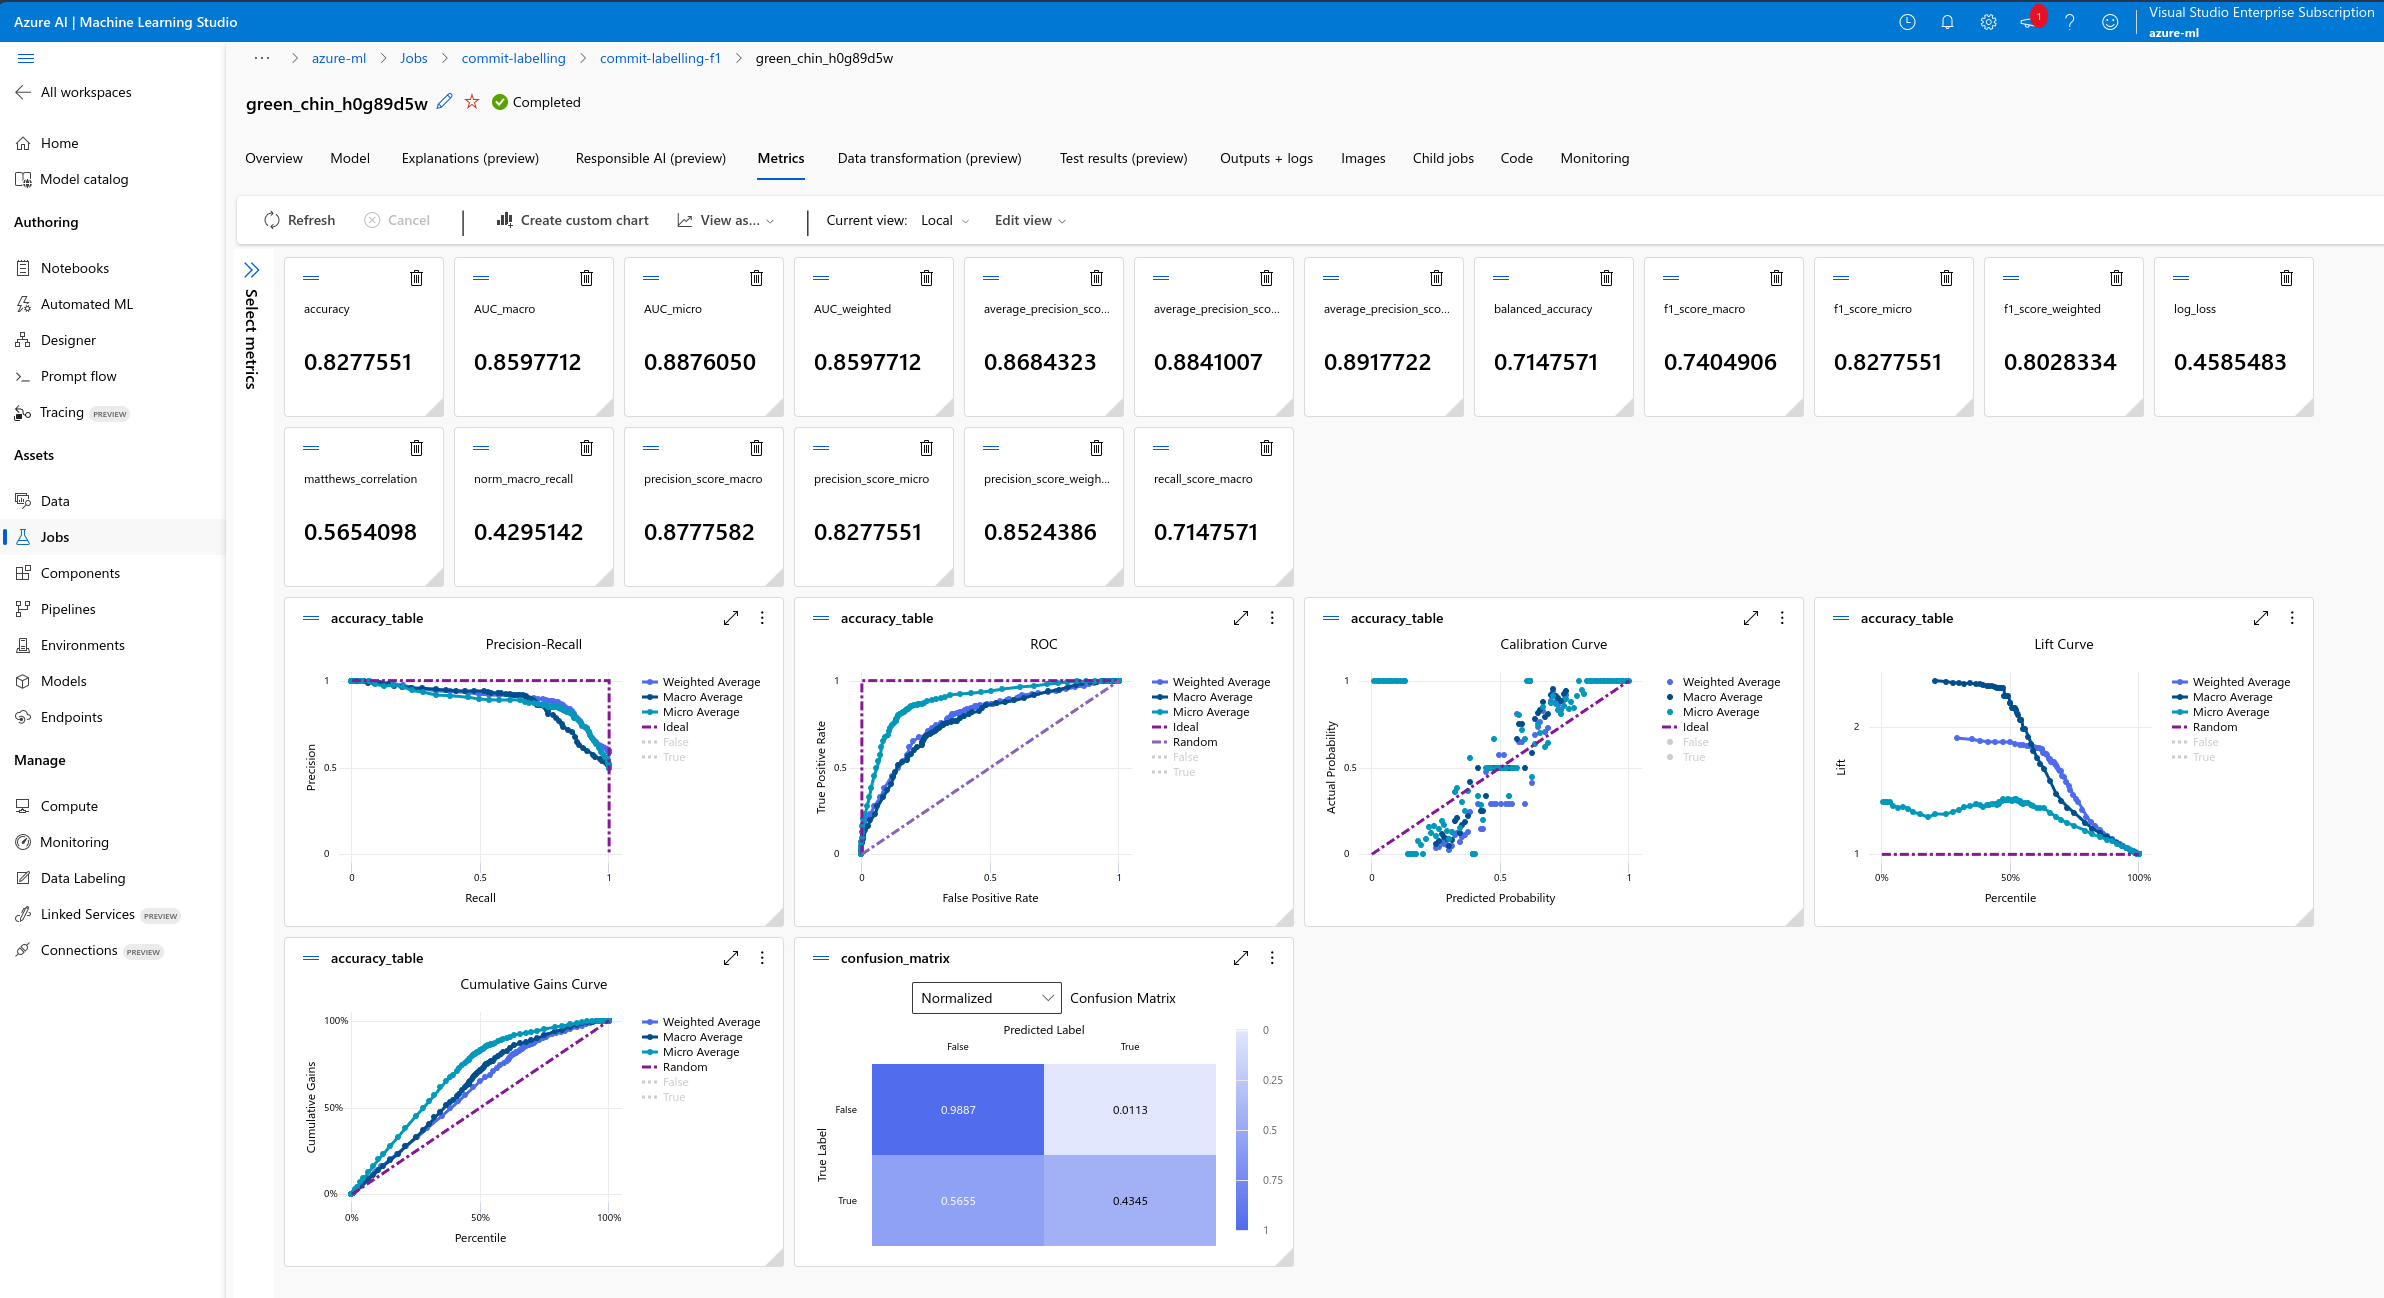

I love the level of detail I get here, and it's the area I most need to help ML.NET catch up in to be a viable machine learning platform for the data science community. My work creating `MLCharts` for this master's project goes a long way towards that.

This overall seems to be a fairly comparable model to what I've seen before, though.

For reference, this is a voting ensemble model composed of 10 child models with different scalars. 8 of these models are random forests or extreme random forests while the other two use logistic regression and XGBoost.

In [58]:
modelTracker.Register("Azure ML Studio Automated ML", 63, 82, 4, 350)

DefaultMetric,F1Score
Count,22


### Azure Machine Learning Automated ML with Deep Learning

Azure Machine Learning Studio's Automated ML also supports deep learning scenarios for text classification and that seemed appropriate given what I was trying to do and the results I've seen on other experiments using this platform.

Instead of using serverless compute like I was able to do for the prior experiment, this did involve running on a dedicated GPU. I ran this experiment on a low priority Standard_NC6s_v3 VM with 6 cores, 112 GB RAM and a NVIDIA Tesla V100 GPU for just over 1 hour.

This identified the following model as its best model of the 46 it evaluated during that time:

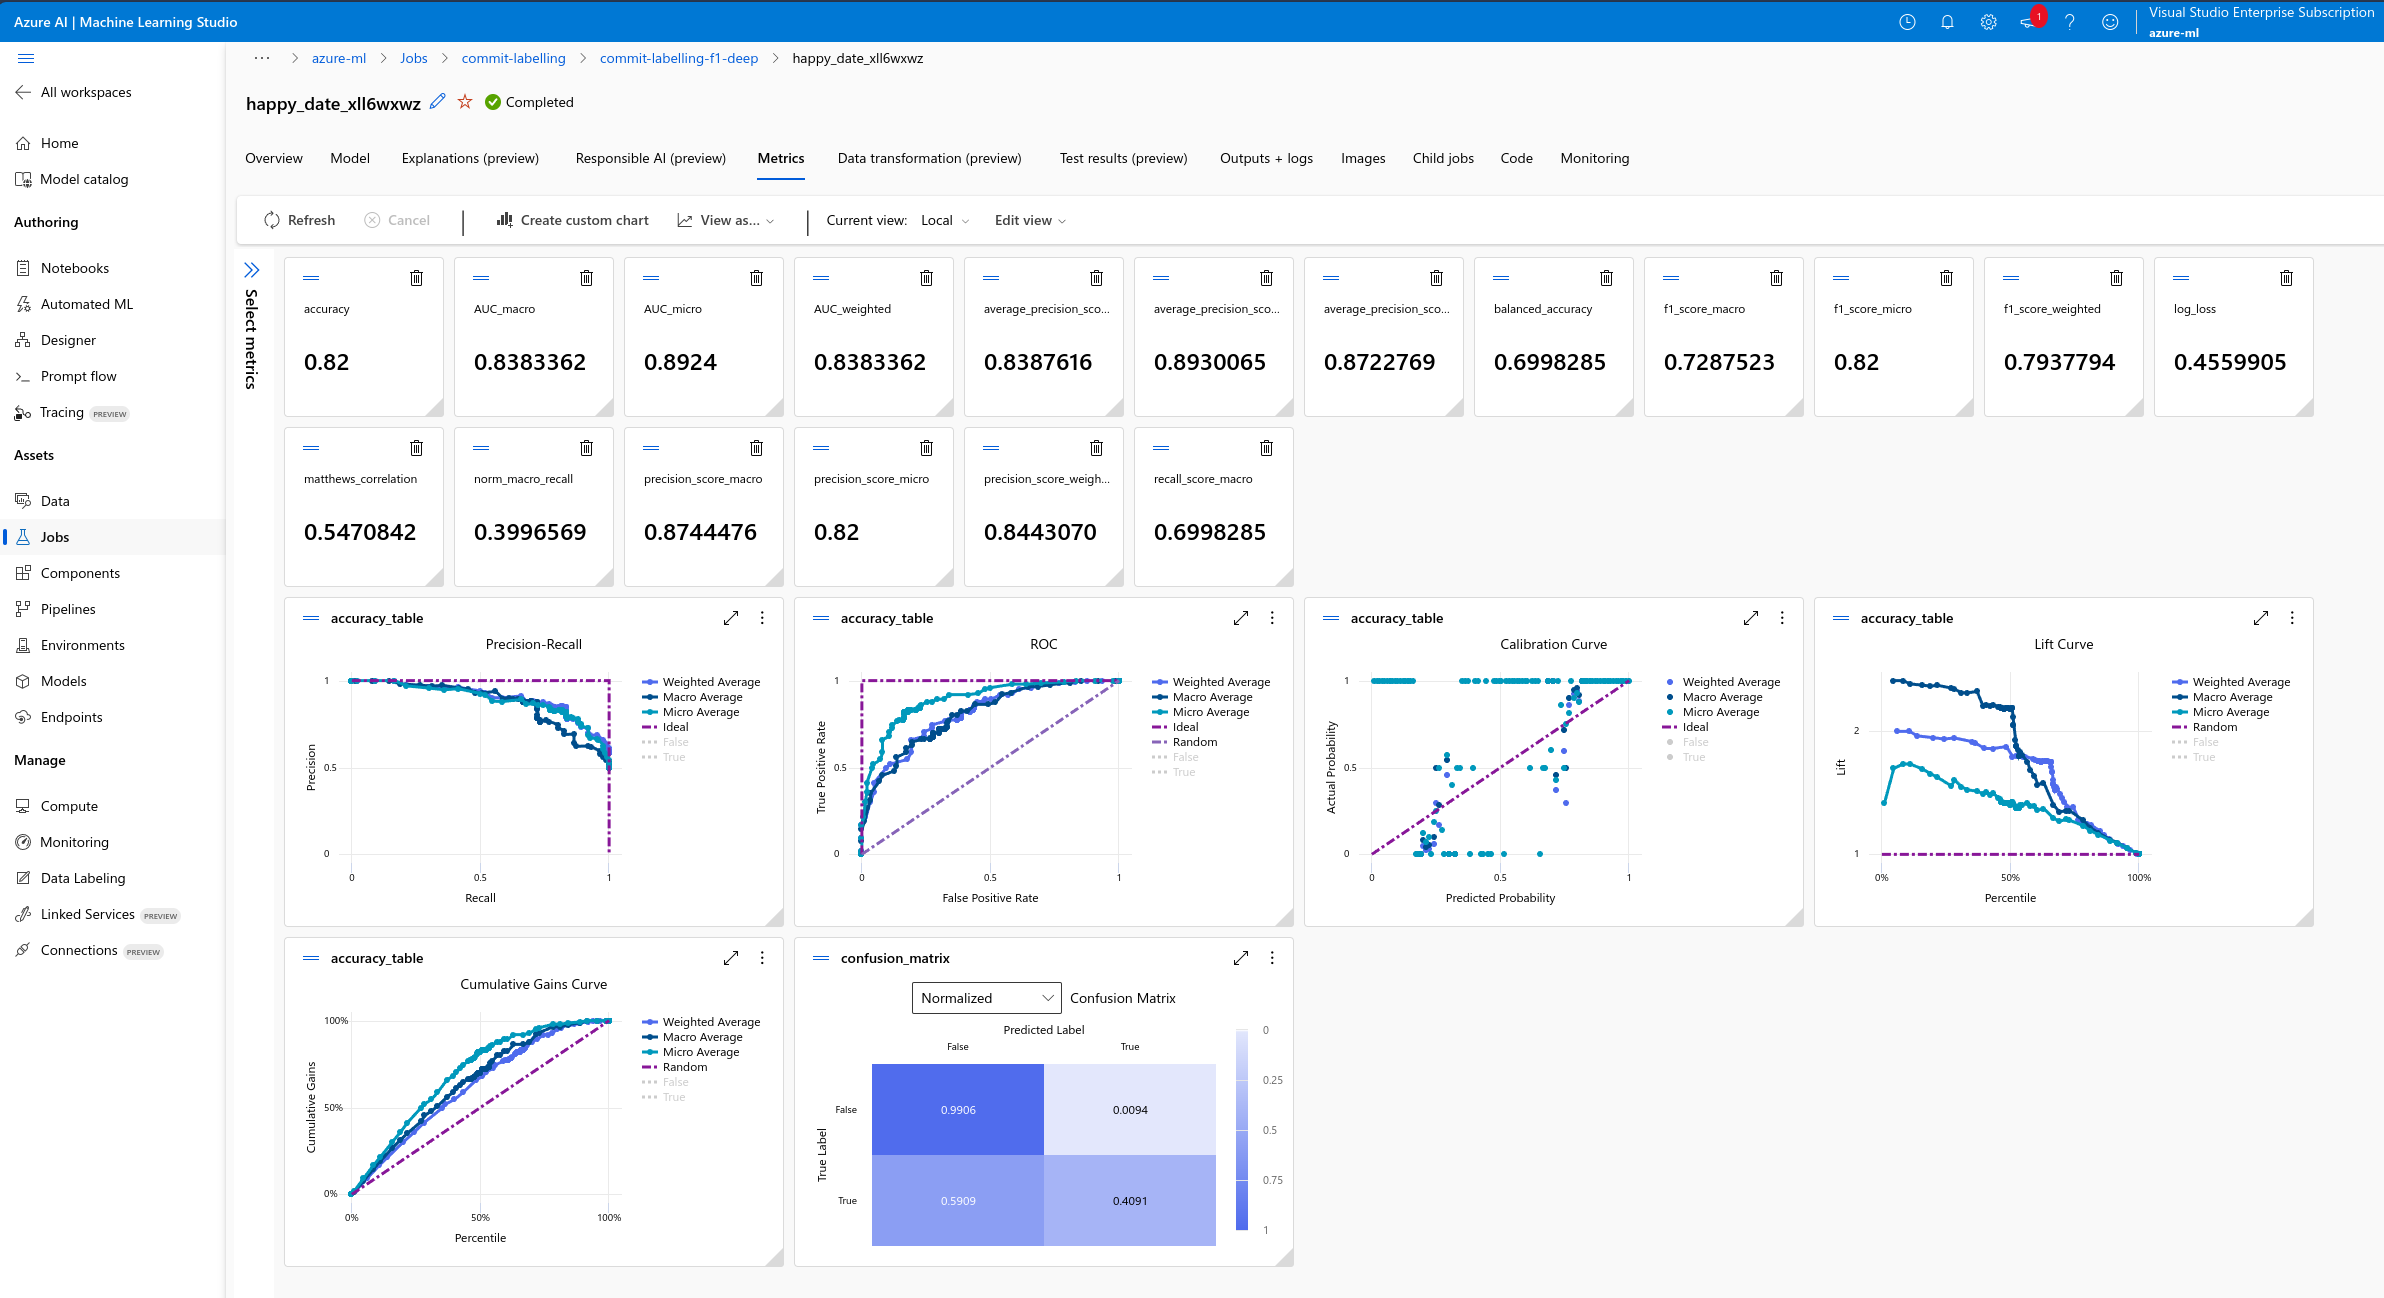

Here again we see a good model and another ensemble model, this time with 4 XGBoosts, 1 SGD, 2 Random Forests, and a LightGBM.

In [59]:
modelTracker.Register("Azure ML Studio Automated ML w. Deep Learning", 18, 26, 1, 105)

DefaultMetric,F1Score
Count,23


### SciKit-Learn Models

I performed dedicated evaluation of common SciKit-Learn binary classification model trainers in `ModelTrainingPython.ipynb`. While these experiments didn't involve as robust of a processing pipeline or any hyperparameter tuning, I wanted to include them as a quick check to ensure I wasn't overlooking algorithms that could perform better than what I was considering in ML.NET. Again, ML.NET is my preferred model platform because it would integrate very easily into GitStractor, though SciKit-Learn or other platforms with ONNX export are also viable models to consider.

In [60]:
// Load the metrics from SciKit-Learn and merge them into our DataFrame
var dfSkLearn = DataFrame.LoadCsv("data/sklearn_models.csv", separator: ',', header: true);
modelTracker.Merge(dfSkLearn);

dfSkLearn

index,Model,F1 Score,Accuracy,Positive Precision,Positive Recall,Negative Precision,Negative Recall,AUC,AUCPR
0,SciKit-Learn RandomForest,0.11655914,0.72743434,1,0.062068965,0.722449,1,0.79256225,0.72843164
1,SciKit-Learn SVC,0.5151479,0.80357575,0.89830506,0.36551723,0.7909091,0.9830508,0.8224089,0.7444055
2,SciKit-Learn LogisticRegression,0.21262464,0.74343437,0.9047619,0.13103448,0.7364017,0.99435025,0.79452163,0.6942291
3,SciKit-Learn MultinomialNB,0.42165935,0.7434949,0.60240966,0.3448276,0.77163464,0.90677965,0.7541789,0.61116856
4,SciKit-Learn KNeighbors,0.052473117,0.71741414,1,0.027586207,0.7151515,1,0.6781059,0.46135667
5,SciKit-Learn MLP,0.33737585,0.74949497,0.6923077,0.24827586,0.75615215,0.9548023,0.76464856,0.6409752


## Model Decision-Making

Now that we've evaluated a lot of candidate models at a basic level, let's do some comparisons and determine which model(s) we should focus more on with hyperparameter tuning.

In [71]:
var dfModels = modelTracker.ToDataFrame();

DataFrame.SaveCsv(dfModels, "data/InitialModelsEvaluated.csv", separator: ',', header: true);
dfModels = DataFrame.LoadCsv("data/InitialModelsEvaluated.csv", separator: ',', header: true);
dfModels.OrderByDescending("F1 Score").Head(15)

index,Model,F1 Score,Accuracy,Positive Precision,Positive Recall,Negative Precision,Negative Recall,AUC,AUCPR
0,Phi-3 LLM Classifier,0.71611255,0.778,0.5691057,0.9655172,0.98031497,0.70140845,0.83346283,0.7747103
1,CustomPipeline - Fast Forest,0.6909091,0.81914896,0.82608694,0.59375,0.8169014,0.9354839,0.83089715,0.7979979
2,Simple AutoML - 10% Test Split,0.6666667,0.78571427,0.9,0.5294118,0.75,0.96,0.7847059,0.79161674
3,Simple AutoML - Additional Training Time,0.6571429,0.8356164,1,0.4893617,0.80487806,1,0.82333976,0.7960886
4,CustomPipelineAuto,0.6551724,0.78723407,0.7307692,0.59375,0.8088235,0.88709676,0.8001512,0.7660228
5,CustomPipeline - Fast Tree,0.6551724,0.78723407,0.7307692,0.59375,0.8088235,0.88709676,0.7920867,0.7585989
6,CustomPipeline - LBFGS Logistic Regression,0.6545454,0.79787236,0.7826087,0.5625,0.8028169,0.91935486,0.77721775,0.7463409
7,TextFeaturizerAuto,0.6530612,0.81914896,0.9411765,0.5,0.7922078,0.983871,0.828125,0.81012326
8,Simple AutoML - 30% Test Split,0.6388889,0.82191783,0.92,0.4893617,0.8016529,0.97979796,0.78497744,0.7463018
9,Simple AutoML - Cross Validation,0.6376812,0.8287671,1,0.4680851,0.7983871,1,0.77401674,0.72246146


Looks like my best models in terms of F1 Score are:

1. Phi-3 LLM
2. Fast Forest
3. Fast Tree
4. Logistic Regression
5. LGBM

_Note: Simple AutoML models excluded from this list because they're primarily just other instances of Fast Forest and Fast Tree models and would be harder to hyperparameter tune_

Of these models, the best positive precisions comes from fast forest, logistic regression, and LGBM. Notably, SVC from SciKit-Learn has high precision as do both ensemble models from Azure Machine Learning Studio, however these models are slightly worse overall due to their F1 Scores and lower recalls.

Phi-3 LLM should be removed from consideration due to its low precision and high execution time, so the remainder of this notebook will be focused on exploring hyperparameter tuning of the remaining 4 models plus a few other targeted comparisons from individual models ML.NET offers outside of AutoML.

## Developing Final Models

In [72]:
modelTracker = new BinaryClassificationModelTracker();

### Fast Forest

In [73]:
public class HypertuningParameters {
    public int NumberOfLeaves { get; set; }
    public int NumberOfTrees { get; set; }
    public int MinimumExampleCountPerLeaf { get; set; }
    public double FeatureFraction { get; set; }
}

SearchSpace<HypertuningParameters> searchSpace = new();
searchSpace["NumberOfTrees"] = new UniformIntOption(3, 12, defaultValue: 4);
searchSpace["NumberOfLeaves"] = new UniformIntOption(10, 100, defaultValue: 10);
searchSpace["FeatureFraction"] = new UniformDoubleOption(0.5, 0.9, defaultValue: 0.78);
searchSpace["MinimumExampleCountPerLeaf"] = new UniformIntOption(1, 20, defaultValue: 5);

monitor = context.Monitor();

SweepableEstimator estimator = context.Auto().CreateSweepableEstimator((context, options) => 
    context.BinaryClassification.Trainers.FastForest(new FastForestBinaryTrainer.Options() {
        NumberOfTrees = options.NumberOfTrees,
        NumberOfLeaves = options.NumberOfLeaves,
        FeatureFraction = options.FeatureFraction,
        MinimumExampleCountPerLeaf = options.MinimumExampleCountPerLeaf,
    }), searchSpace);

var result = await context.Auto().CreateExperiment()
    .SetPipeline(basePipeline.Append(estimator))
    .SetDataset(split.TrainSet, fold: 5)
    .SetBinaryClassificationMetric(BinaryClassificationMetric.F1Score, labelColumn: "Label", predictedColumn: "Label")
    .SetMaxModelToExplore(50)
    .SetEciCostFrugalTuner()
    .RunAsync();

// Let's see how it performed
ITransformer model = result.Model;
var evalResults = context.BinaryClassification.EvaluateNonCalibrated(model.Transform(split.TestSet), labelColumnName: "Label", predictedLabelColumnName: "Label");

modelTracker.Register("Hyperparameter-Tuned FastForest", evalResults);
var chart = MLCharts.ClassificationReport(evalResults);
chart.Display();

// Display the Hyperparameters for our best trial
monitor.BestTrial.Hyperparameters.Display();

MLCharts.MetricImprovementWithTrials(monitor).Display();

// Calculate the permutation feature importance and list the top 10 features by their autogenerated names
context.BinaryClassification.PermutationFeatureImportanceNonCalibrated(model, model.Transform(df.Sample(50)), permutationCount:1)
        .OrderByDescending(f => Math.Abs(f.Value.F1Score.Mean))
        .Where(f => Math.Abs(f.Value.F1Score.Mean) > 0)
        .Take(10)
        .Select(f => new {Feature=f.Key, Impact=f.Value.F1Score.Mean}).Display();    

ITransformer fastForestModel = model;

<!-- Plotly chart will be drawn inside this DIV -->

Key,Value
FeatureFraction,0.7216554134339095
MinimumExampleCountPerLeaf,3
NumberOfLeaves,10
NumberOfTrees,3


<!-- Plotly chart will be drawn inside this DIV -->

index value 0 { Feature = MessageChars.i|x, Impact = -0.2504201680672271 } Feature MessageChars.i|x Impact -0.2504201680672271 1 { Feature = MessageChars.i|s|s, Impact = -0.05882352941176483 } Feature MessageChars.i|s|s Impact -0.05882352941176483 2 { Feature = MessageChars.<␠>|o|n, Impact = -0.042483660130719136 } Feature MessageChars.<␠>|o|n Impact -0.042483660130719136 3 { Feature = MessageChars.s|r|e, Impact = -0.03743315508021405 } Feature MessageChars.s|r|e Impact -0.03743315508021405 4 { Feature = MessageChars.t|h|o, Impact = -0.03743315508021405 } Feature MessageChars.t|h|o Impact -0.03743315508021405 5 { Feature = MessageChars.<␂>|h, Impact = -0.03743315508021405 } Feature MessageChars.<␂>|h Impact -0.03743315508021405 6 { Feature = MessageChars.m|s|s, Impact = -0.03743315508021405 } Feature MessageChars.m|s|s Impact -0.03743315508021405 7 { Feature = MessageChars.s|s|<␠>, Impact = 0.0231729055258465 } Feature MessageChars.s|s|<␠> Impact 0.0231729055258465 8 { Feature = MessageChars.e|i, Impact = -0.021848739495798353 } Feature MessageChars.e|i Impact -0.021848739495798353 9 { Feature = MessageChars.<␠>|n|<␠>, Impact = -0.021848739495798353 } Feature MessageChars.<␠>|n|<␠> Impact -0.021848739495798353

Overall this is a very good model with a high F1 Score and precision. It limits the complexity of the random forest by restricting tree count and leaf count and only uses 72% of the data for the tree / forest forming. This gives me a lot more confidence that the model hasn’t overfit, in addition to the use of cross-validation and reserve validation metrics. Finally, the most important features seem to involve substrings like “fix” and “issue”, so I find this model to be reasonable.

### LBFGS Logistic Regression

In [74]:
public class HypertuningParameters {
    public float L1Regularization { get; set; }
    public float L2Regularization { get; set; }
}

SearchSpace<HypertuningParameters> searchSpace = new();
searchSpace["L1Regularization"] = new UniformDoubleOption(0, 1, defaultValue: 0.07);
searchSpace["L2Regularization"] = new UniformDoubleOption(0, 1, defaultValue: 0.005);

SweepableEstimator estimator = context.Auto().CreateSweepableEstimator((context, options) => 
    context.BinaryClassification.Trainers.LbfgsLogisticRegression(new LbfgsLogisticRegressionBinaryTrainer.Options() {
        L1Regularization = options.L1Regularization,
        L2Regularization = options.L2Regularization,
        
    }), searchSpace);        

var result = await context.Auto().CreateExperiment()
    .SetPipeline(basePipeline.Append(estimator))
    .SetDataset(split.TrainSet, fold: 5) // Cross-validation using 90% of the data
    .SetBinaryClassificationMetric(BinaryClassificationMetric.F1Score, labelColumn: "Label", predictedColumn: "Label")
    .SetMaxModelToExplore(50)
    .SetEciCostFrugalTuner()
    .RunAsync();

// Let's see how it performed
ITransformer model = result.Model;
var evalResults = context.BinaryClassification.EvaluateNonCalibrated(model.Transform(split.TestSet), labelColumnName: "Label", predictedLabelColumnName: "Label");

modelTracker.Register("Hyperparameter-Tuned Logistic Regression", evalResults).ToDataFrame();
var chart = MLCharts.ClassificationReport(evalResults);
chart.Display();

// Display the Hyperparameters for our best trial
monitor.BestTrial.Hyperparameters.Display();

MLCharts.MetricImprovementWithTrials(monitor).Display();

// Calculate the permutation feature importance and list the top 10 features by their autogenerated names
context.BinaryClassification.PermutationFeatureImportanceNonCalibrated(model, model.Transform(df.Sample(50)), permutationCount:1)
        .OrderByDescending(f => Math.Abs(f.Value.F1Score.Mean))
        .Where(f => Math.Abs(f.Value.F1Score.Mean) > 0)
        .Take(10)
        .Select(f => new {Feature=f.Key, Impact=f.Value.F1Score.Mean}).Display();     

ITransformer logisticModel = model;

<!-- Plotly chart will be drawn inside this DIV -->

Key,Value
L1Regularization,0.08492753204758478
L2Regularization,0.00030194708623875334


<!-- Plotly chart will be drawn inside this DIV -->

index value 0 { Feature = WordCount, Impact = -0.22571428571428553 } Feature WordCount Impact -0.22571428571428553 1 { Feature = MessageWords.bad, Impact = -0.04497354497354478 } Feature MessageWords.bad Impact -0.04497354497354478 2 { Feature = MessageChars.i|x, Impact = 0.041871921182266236 } Feature MessageChars.i|x Impact 0.041871921182266236 3 { Feature = MessageChars.f|x, Impact = 0.041871921182266236 } Feature MessageChars.f|x Impact 0.041871921182266236 4 { Feature = AddedFiles, Impact = 0.029100529100529182 } Feature AddedFiles Impact 0.029100529100529182 5 { Feature = MessageWords.kernel, Impact = 0.029100529100529182 } Feature MessageWords.kernel Impact 0.029100529100529182 6 { Feature = MessageChars.x, Impact = 0.029100529100529182 } Feature MessageChars.x Impact 0.029100529100529182 7 { Feature = MessageWords.update, Impact = 0.029100529100529182 } Feature MessageWords.update Impact 0.029100529100529182 8 { Feature = MessageChars.f|i, Impact = -0.027093596059113212 } Feature MessageChars.f|i Impact -0.027093596059113212 9 { Feature = MessageChars.c, Impact = -0.016483516483516425 } Feature MessageChars.c Impact -0.016483516483516425

Another decent model. The F1 score and precision aren't as good as the random forest's, but logistic regression gives me much more confidence that we haven't overfit and it's likely to be very fast for inferencing. The explanations make a bit more sense than the random forest's and include factors beyond just the message, so this may be a more generalized model that happens to perform worse on the final validation data set.

### Light GBM

In [75]:
public class HypertuningParameters {
    public int NumberOfLeaves { get; set; }
    public int NumberOfTrees { get; set; }
    public double LearningRate { get; set; }
    public int MinimumExampleCountPerLeaf { get; set; }
}

SearchSpace<HypertuningParameters> searchSpace = new();
searchSpace["NumberOfLeaves"] = new UniformIntOption(5, 30, defaultValue: 10);
searchSpace["NumberOfTrees"] = new UniformIntOption(1, 12, defaultValue: 3);
searchSpace["LearningRate"] = new UniformDoubleOption(0, 1, defaultValue: 0.5);
searchSpace["MinimumExampleCountPerLeaf"] = new UniformIntOption(0, 10, defaultValue: 5);

SweepableEstimator estimator = context.Auto().CreateSweepableEstimator((context, options) => 
    context.BinaryClassification.Trainers.LightGbm(new Microsoft.ML.Trainers.LightGbm.LightGbmBinaryTrainer.Options() {
        NumberOfLeaves = options.NumberOfLeaves,
        MinimumExampleCountPerLeaf = options.MinimumExampleCountPerLeaf,
        LearningRate = options.LearningRate,
        NumberOfIterations = options.NumberOfTrees
    }), searchSpace);        

var result = await context.Auto().CreateExperiment()
    .SetPipeline(basePipeline.Append(estimator))
    .SetDataset(split.TrainSet, fold: 5) // Cross-validation using 90% of the data
    .SetBinaryClassificationMetric(BinaryClassificationMetric.F1Score, labelColumn: "Label", predictedColumn: "Label")
    .SetMaxModelToExplore(10)
    .SetEciCostFrugalTuner()
    .RunAsync();

// Let's see how it performed
ITransformer model = result.Model;
var evalResults = context.BinaryClassification.EvaluateNonCalibrated(model.Transform(split.TestSet), labelColumnName: "Label", predictedLabelColumnName: "Label");

modelTracker.Register("Hyperparameter-Tuned Light GBM", evalResults).ToDataFrame();
var chart = MLCharts.ClassificationReport(evalResults);
chart.Display();

// Display the Hyperparameters for our best trial
Console.WriteLine("Hyperparameters:\r\n");
foreach (var kvp in monitor.BestTrial.Hyperparameters) {
    Console.WriteLine($"{kvp.Key}: {kvp.Value}");
}

MLCharts.MetricImprovementWithTrials(monitor).Display();

// Calculate the permutation feature importance and list the top 10 features by their autogenerated names
context.BinaryClassification.PermutationFeatureImportanceNonCalibrated(model, model.Transform(df.Sample(50)), permutationCount:1)
        .OrderByDescending(f => Math.Abs(f.Value.F1Score.Mean))
        .Where(f => Math.Abs(f.Value.F1Score.Mean) > 0)
        .Take(10)
        .Select(f => new {Feature=f.Key, Impact=f.Value.F1Score.Mean}).Display();    

ITransformer lightGbmModel = model;

<!-- Plotly chart will be drawn inside this DIV -->

Hyperparameters:

LearningRate: 0.5
MinimumExampleCountPerLeaf: 5
NumberOfLeaves: 10
NumberOfTrees: 3


<!-- Plotly chart will be drawn inside this DIV -->

index value 0 { Feature = MessageChars.i|x, Impact = -0.23529411764705876 } Feature MessageChars.i|x Impact -0.23529411764705876 1 { Feature = MessageChars.<␠>|n|<␠>, Impact = -0.17267552182163182 } Feature MessageChars.<␠>|n|<␠> Impact -0.17267552182163182 2 { Feature = MessageChars.s|u|e, Impact = -0.025210084033613467 } Feature MessageChars.s|u|e Impact -0.025210084033613467 3 { Feature = MessageChars.r|o|r, Impact = -0.025210084033613467 } Feature MessageChars.r|o|r Impact -0.025210084033613467 4 { Feature = MessageChars.i|n|<␠>, Impact = -0.025210084033613467 } Feature MessageChars.i|n|<␠> Impact -0.025210084033613467 5 { Feature = MessageChars.q|u, Impact = -0.025210084033613467 } Feature MessageChars.q|u Impact -0.025210084033613467

This model took 17 minutes to train in its most recent run, for good but not amazing metrics. I have to fear that the training time will increase significantly as the data grows, so I'm afraid to continue forward with this trainer in the future, especially as the PFI seem less relevant than the other two models.

### Linear SVM

In [77]:
public class HypertuningParameters {
    public float Lambda {get; set;}
    public int BatchSize { get; set; }
    public bool NoBias {get; set;}
    public bool Shuffle {get; set;}
    public bool PerformProjection {get; set;}
}

SearchSpace<HypertuningParameters> searchSpace = new();
searchSpace["Lambda"] = new UniformDoubleOption(1E-06f, 1, defaultValue: 0.0001f, logBase: true);
searchSpace["BatchSize"] = new UniformIntOption(1, 128, defaultValue: 1);
searchSpace["NoBias"] = new ChoiceOption(true, false);
searchSpace["Shuffle"] = new ChoiceOption(true, false);
searchSpace["PerformProjection"] = new ChoiceOption(true, false);


SweepableEstimator estimator = context.Auto().CreateSweepableEstimator((context, options) => 
    context.BinaryClassification.Trainers.LinearSvm(new Microsoft.ML.Trainers.LinearSvmTrainer.Options() {
        Lambda = options.Lambda,
        BatchSize = options.BatchSize,
        NoBias = options.NoBias,
        Shuffle = options.Shuffle,
        PerformProjection = options.PerformProjection
    }), searchSpace);        

var result = await context.Auto().CreateExperiment()
    .SetPipeline(basePipeline.Append(estimator))
    .SetDataset(split.TrainSet, fold: 5)
    .SetBinaryClassificationMetric(BinaryClassificationMetric.F1Score, labelColumn: "Label", predictedColumn: "Label")
    .SetMaxModelToExplore(50)
    .SetEciCostFrugalTuner()
    .RunAsync();

// Let's see how it performed
ITransformer model = result.Model;
var evalResults = context.BinaryClassification.EvaluateNonCalibrated(model.Transform(split.TestSet), labelColumnName: "Label", predictedLabelColumnName: "Label");

modelTracker.Register("Hyperparameter-Tuned Linear SVM", evalResults).ToDataFrame();
var chart = MLCharts.ClassificationReport(evalResults);
chart.Display();

// Display the Hyperparameters for our best trial
monitor.BestTrial.Hyperparameters.Display();

MLCharts.MetricImprovementWithTrials(monitor).Display();

// Calculate the permutation feature importance and list the top 10 features by their autogenerated names
context.BinaryClassification.PermutationFeatureImportanceNonCalibrated(model, model.Transform(df.Sample(50)), permutationCount:1)
        .OrderByDescending(f => Math.Abs(f.Value.F1Score.Mean))
        .Where(f => Math.Abs(f.Value.F1Score.Mean) > 0)
        .Take(10)
        .Select(f => new {Feature=f.Key, Impact=f.Value.F1Score.Mean}).Display();    

ITransformer linearSvmModel = model;

<!-- Plotly chart will be drawn inside this DIV -->

Key,Value
BatchSize,1
Lambda,0.00014314041558061833
NoBias,True
PerformProjection,True
Shuffle,True


<!-- Plotly chart will be drawn inside this DIV -->

index value 0 { Feature = NetLines, Impact = -0.1848739495798319 } Feature NetLines Impact -0.1848739495798319 1 { Feature = WorkItems, Impact = 0.15441176470588236 } Feature WorkItems Impact 0.15441176470588236 2 { Feature = MessageLength, Impact = -0.0955882352941177 } Feature MessageLength Impact -0.0955882352941177 3 { Feature = WordCount, Impact = -0.04953560371517024 } Feature WordCount Impact -0.04953560371517024 4 { Feature = MessageChars.c, Impact = -0.026143790849673165 } Feature MessageChars.c Impact -0.026143790849673165

This wasn’t the best of models by any stretch, but what’s interesting is that the model almost entirely ignored the specific string in message and fixated on other attributes.

### Averaged Perceptron

In [79]:
public class HypertuningParameters {
    public float LearningRate {get; set;}
    public bool DecreaseLearningRate {get; set;}
    public float L2Regularization {get; set;}
}

SearchSpace<HypertuningParameters> searchSpace = new();
searchSpace["LearningRate"] = new UniformDoubleOption(0.0001f, 1f, defaultValue: 0.98f, logBase: true);
searchSpace["L2Regularization"] = new UniformDoubleOption(0, 5, defaultValue: 0f);
searchSpace["DecreaseLearningRate"] = new ChoiceOption(true, false);

SweepableEstimator estimator = context.Auto().CreateSweepableEstimator((context, options) => 
    context.BinaryClassification.Trainers.AveragedPerceptron(new Microsoft.ML.Trainers.AveragedPerceptronTrainer.Options() {
        LearningRate = options.LearningRate,
        L2Regularization = options.L2Regularization,
        DecreaseLearningRate = options.DecreaseLearningRate
    }), searchSpace);        

var result = await context.Auto().CreateExperiment()
    .SetPipeline(basePipeline.Append(estimator))
    .SetDataset(split.TrainSet, fold: 5) // Cross-validation using 90% of the data
    .SetBinaryClassificationMetric(BinaryClassificationMetric.F1Score, labelColumn: "Label", predictedColumn: "Label")
    .SetMaxModelToExplore(50)
    .SetEciCostFrugalTuner()
    .RunAsync();

// Let's see how it performed
ITransformer model = result.Model;
var evalResults = context.BinaryClassification.EvaluateNonCalibrated(model.Transform(split.TestSet), labelColumnName: "Label", predictedLabelColumnName: "Label");

modelTracker.Register("Hyperparameter-Tuned Averaged Perceptron", evalResults).ToDataFrame();
var chart = MLCharts.ClassificationReport(evalResults);
chart.Display();

// Display the Hyperparameters for our best trial
monitor.BestTrial.Hyperparameters.Display();

MLCharts.MetricImprovementWithTrials(monitor).Display();

// Calculate the permutation feature importance and list the top 10 features by their autogenerated names
context.BinaryClassification.PermutationFeatureImportanceNonCalibrated(model, model.Transform(df.Sample(50)), permutationCount:1)
        .OrderByDescending(f => Math.Abs(f.Value.F1Score.Mean))
        .Where(f => Math.Abs(f.Value.F1Score.Mean) > 0)
        .Take(10)
        .Select(f => new {Feature=f.Key, Impact=f.Value.F1Score.Mean}).Display();    

ITransformer averagedPerceptronModel = model;

<!-- Plotly chart will be drawn inside this DIV -->

Key,Value
DecreaseLearningRate,True
L2Regularization,0
LearningRate,0.9909187220538312


<!-- Plotly chart will be drawn inside this DIV -->

index value 0 { Feature = MessageLength, Impact = -0.161904761904762 } Feature MessageLength Impact -0.161904761904762 1 { Feature = MessageWords.fix, Impact = -0.13032581453634096 } Feature MessageWords.fix Impact -0.13032581453634096 2 { Feature = WordCount, Impact = -0.13032581453634096 } Feature WordCount Impact -0.13032581453634096 3 { Feature = NetLines, Impact = -0.13032581453634096 } Feature NetLines Impact -0.13032581453634096 4 { Feature = HasAddedFiles, Impact = -0.09523809523809534 } Feature HasAddedFiles Impact -0.09523809523809534 5 { Feature = MessageWords.readonly, Impact = -0.06190476190476191 } Feature MessageWords.readonly Impact -0.06190476190476191 6 { Feature = MessageWords.update, Impact = -0.06190476190476191 } Feature MessageWords.update Impact -0.06190476190476191 7 { Feature = MessageChars.a, Impact = -0.06190476190476191 } Feature MessageChars.a Impact -0.06190476190476191 8 { Feature = AddedLines, Impact = -0.06190476190476191 } Feature AddedLines Impact -0.06190476190476191 9 { Feature = DeletedLines, Impact = -0.06190476190476191 } Feature DeletedLines Impact -0.06190476190476191

Another interesting result that focused on other attributes, though it does have presence factors for readonly, fix, and update.

### Field-Aware Factorization Machine

In [82]:
public class HypertuningParameters {
    public float LearningRate {get; set;}
    public int NumberOfIterations {get; set;}
    public int LatentDimension {get; set;}
    public float LambdaLinear {get; set;}
    public float LambdaLatent {get; set;}
    public float Radius {get; set;}
}

SearchSpace<HypertuningParameters> searchSpace = new();
searchSpace["LearningRate"] = new UniformDoubleOption(0.0001f, 1f, defaultValue: 0.98f, logBase: true);
searchSpace["NumberOfIterations"] = new UniformIntOption(0, 20, defaultValue: 5);
searchSpace["LatentDimension"] = new UniformIntOption(4, 100, defaultValue: 20);
searchSpace["LambdaLinear"] = new UniformDoubleOption(1E-08f, 1, defaultValue: 0.0001f);
searchSpace["LambdaLatent"] = new UniformDoubleOption(1E-08f, 1, defaultValue: 0.0001f);
searchSpace["Radius"] = new UniformDoubleOption(0.1, 1, defaultValue: 0.5f);

SweepableEstimator estimator = context.Auto().CreateSweepableEstimator((context, options) => 
    context.BinaryClassification.Trainers.FieldAwareFactorizationMachine(new Microsoft.ML.Trainers.FieldAwareFactorizationMachineTrainer.Options() {
        LearningRate = options.LearningRate,
        NumberOfIterations = options.NumberOfIterations,
        LatentDimension = options.LatentDimension,
        LambdaLinear = options.LambdaLinear,
        LambdaLatent = options.LambdaLatent,
        Radius = options.Radius
    }), searchSpace);        

var result = await context.Auto().CreateExperiment()
    .SetPipeline(basePipeline.Append(estimator))
    .SetDataset(split.TrainSet, fold: 5)
    .SetBinaryClassificationMetric(BinaryClassificationMetric.F1Score, labelColumn: "Label", predictedColumn: "Label")
    .SetMaxModelToExplore(500)
    .SetEciCostFrugalTuner()
    .RunAsync();

// Let's see how it performed
ITransformer model = result.Model;
var evalResults = context.BinaryClassification.EvaluateNonCalibrated(model.Transform(split.TestSet), labelColumnName: "Label", predictedLabelColumnName: "Label");

modelTracker.Register("Hyperparameter-Tuned Field-Aware Factorization Machine", evalResults).ToDataFrame();
var chart = MLCharts.ClassificationReport(evalResults);
chart.Display();

// Display the Hyperparameters for our best trial
monitor.BestTrial.Hyperparameters.Display();

MLCharts.MetricImprovementWithTrials(monitor).Display();

// Note: Field-Aware Factorization Machine does not support permutation feature importance
ITransformer fafmModel = model;

<!-- Plotly chart will be drawn inside this DIV -->

Key,Value
LambdaLatent,0.08650302327178121
LambdaLinear,0.00225567044554754
LatentDimension,4
LearningRate,0.9252679487115824
NumberOfIterations,8
Radius,0.5579180381401185


<!-- Plotly chart will be drawn inside this DIV -->

Field-aware factorization machines seem like they might be good for this problem since they work well on sparse high-dimensionality data. To help with this, I gave the trainer additional training time, and it’s interesting to see the performance of the various iterations as it searched for better options than its initial area of interest up to trial 70 or so.

Overall, the metrics are fine, but not amazing and the lack of PFI support in ML.NET gives me lowered confidence in the model overall.

### Local Deep Learning Support Vector Machine

[Research Article](https://www.microsoft.com/en-us/research/video/local-deep-kernel-learning-for-efficient-non-linear-svm-prediction-2/)

In [83]:
var pipeline = basePipeline.Append(context.BinaryClassification.Trainers.LdSvm(new LdSvmTrainer.Options() {
    TreeDepth = 5,
    LambdaW = 0.1f,
    LambdaTheta = 0.01f,
    LambdaThetaprime = 0.01f,
    Sigma = 1f,
    UseBias = true,
    NumberOfIterations = 1500,
}));

var model = pipeline.Fit(split.TrainSet);

// Let's see how it performed
var evalResults = context.BinaryClassification.EvaluateNonCalibrated(model.Transform(split.TestSet), labelColumnName: "Label", predictedLabelColumnName: "Label");

modelTracker.Register("Local Deep Learning Support Vector Machine", evalResults).ToDataFrame();
var chart = MLCharts.ClassificationReport(evalResults);
chart.Display();

ITransformer ldSvmModel = model;

<!-- Plotly chart will be drawn inside this DIV -->

In [84]:
    context.BinaryClassification.PermutationFeatureImportanceNonCalibrated(model, model.Transform(df), permutationCount:3)
        .OrderByDescending(f => Math.Abs(f.Value.F1Score.Mean))
        .Where(f => Math.Abs(f.Value.F1Score.Mean) > 0)
        .Take(10)
        .Select(f => new {Feature=f.Key, Impact=f.Value.F1Score.Mean}).Display();    


index value 0 { Feature = WordCount, Impact = -0.11192429213258837 } Feature WordCount Impact -0.11192429213258837 1 { Feature = HasAddedFiles, Impact = -0.01108652348257222 } Feature HasAddedFiles Impact -0.01108652348257222 2 { Feature = MessageLength, Impact = -0.007821374733165243 } Feature MessageLength Impact -0.007821374733165243 3 { Feature = MessageWords.test, Impact = 0.0074044079365997995 } Feature MessageWords.test Impact 0.0074044079365997995 4 { Feature = MessageChars.t, Impact = 0.007212240674214628 } Feature MessageChars.t Impact 0.007212240674214628 5 { Feature = MessageChars.<␠>, Impact = 0.006239517727501975 } Feature MessageChars.<␠> Impact 0.006239517727501975 6 { Feature = MessageWords.enable, Impact = 0.006239517727501975 } Feature MessageWords.enable Impact 0.006239517727501975 7 { Feature = MessageChars.t|<␠>, Impact = 0.005788891210636711 } Feature MessageChars.t|<␠> Impact 0.005788891210636711 8 { Feature = MessageWords.fix, Impact = -0.005132584261409279 } Feature MessageWords.fix Impact -0.005132584261409279 9 { Feature = MessageWords.bug, Impact = -0.004768806395810898 } Feature MessageWords.bug Impact -0.004768806395810898

A decent model, and an interesting use of deep learning, but its F1 Score and Precision are too low for serious consideration.

# Selecting our Final Model

In [90]:
DataFrame.SaveCsv(modelTracker.ToDataFrame(), "data/FinalModels.csv");
DataFrame dfFinalModels = DataFrame.LoadCsv("data/FinalModels.csv", separator: ',', header: true);
dfFinalModels.OrderByDescending("F1 Score")

index,Model,F1 Score,Accuracy,Positive Precision,Positive Recall,Negative Precision,Negative Recall,AUC,AUCPR
0,Hyperparameter-Tuned FastForest,0.71428573,0.82978725,0.8333333,0.625,0.82857144,0.9354839,0.79133064,0.7502335
1,Hyperparameter-Tuned Light GBM,0.6875,0.78723407,0.6875,0.6875,0.83870965,0.83870965,0.827621,0.7087391
2,Hyperparameter-Tuned Logistic Regression,0.64285713,0.78723407,0.75,0.5625,0.8,0.9032258,0.7872984,0.7668868
3,Hyperparameter-Tuned Field-Aware Factorization Machine,0.6333333,0.7659575,0.6785714,0.59375,0.8030303,0.8548387,0.7857863,0.7306024
4,Local Deep Learning Support Vector Machine,0.5970149,0.71276593,0.5714286,0.625,0.7966102,0.7580645,0.75403225,0.72068
5,Hyperparameter-Tuned Averaged Perceptron,0.53061223,0.7553192,0.7647059,0.40625,0.7532467,0.9354839,0.6950605,0.66377735
6,Hyperparameter-Tuned Linear SVM,0.48,0.7234042,0.6666667,0.375,0.7368421,0.9032258,0.6764113,0.6367221


And the winner is... the Random Forest: `Hyperparameter-Tuned FastForest`. Althought it's possible this model is slightly overfit, I believe it to be my best option going forward. It's explainability makes sense and its high positive prediction gives me more confidence than the Light GBM or Logistic Regression models.

If the model's accuracy on other data points doesn't match expectations, we can switch to Light GBM or Logistic Regression or increase the volume of training data and try again, but I believe the random forest is our winner.

In [93]:
context.Model.Save(fastForestModel, ((IDataView)df).Schema, $"models/FastForest.zip");
context.Model.Save(lightGbmModel, ((IDataView)df).Schema, $"models/LightGBM.zip");
context.Model.Save(logisticModel, ((IDataView)df).Schema, $"models/LogisticRegression.zip");

## Testing our Model

In [95]:
public class CommitClassification {
    public bool PredictedLabel { get; set; }
    public float Probability { get; set; }
}

ITransformer model = fastForestModel;

var engine = context.Model.CreatePredictionEngine<CommitInfo, CommitClassification>(model);

In [97]:
var commit = new CommitInfo {
    Message = "Fixes issue #1234",
    IsMerge = false,
    WorkItems = 1,
    TotalFiles = 1,
    ModifiedFiles = 1,
    AddedFiles = 0,
    DeletedFiles = 0,
    TotalLines = 10,
    NetLines = 10,
    AddedLines = 0,
    DeletedLines = 0,
    HasAddedFiles = false,
    HasDeletedFiles = false,
    MessageLength = 16,
    WordCount = 3
};

var prediction = engine.Predict(commit);
prediction.PredictedLabel

True

In [98]:
var commit = new CommitInfo {
    Message = "Added a Dark Theme",
    IsMerge = false,
    WorkItems = 1,
    TotalFiles = 8,
    ModifiedFiles = 2,
    AddedFiles = 6,
    DeletedFiles = 0,
    TotalLines = 196,
    NetLines = 55,
    AddedLines = 88,
    DeletedLines = 37,
    HasAddedFiles = true,
    HasDeletedFiles = false,
    MessageLength = 20,
    WordCount = 4
};

var prediction = engine.Predict(commit);
prediction.PredictedLabel

False

## Checking Accuracy Per Repository

Now that we have our model, let's see how its accuracy holds up for different repositories of data.

In [99]:
df["Source"].ValueCounts()

index,Values,Counts
0,dotnetinteractive,289
1,emergence,34
2,gitstractor,16
3,mlnet,146
4,wherewolf,14


In [102]:
Dictionary<string, DataFrame> dfsBySource = new();

foreach (var source in df["Source"].Cast<string>().Distinct()) {
    dfsBySource[source] = df.Filter(df["Source"].ElementwiseEquals(source));
}

foreach (var kvp in dfsBySource) {
    string source = kvp.Key;
    DataFrame dfSource = kvp.Value;

    var sourceEval = context.BinaryClassification.EvaluateNonCalibrated(model.Transform(dfSource), labelColumnName: "Label", predictedLabelColumnName: "Label");
    Console.WriteLine($"Source: {source}, F1 Score: {sourceEval.F1Score:F2}, Precision: {sourceEval.PositivePrecision:F2}, Recall: {sourceEval.PositiveRecall:F2}");
}

Source: dotnetinteractive, F1 Score: 0.84, Precision: 0.94, Recall: 0.76
Source: emergence, F1 Score: 0.67, Precision: 0.67, Recall: 0.67
Source: gitstractor, F1 Score: 0.60, Precision: 1.00, Recall: 0.43
Source: mlnet, F1 Score: 0.79, Precision: 0.88, Recall: 0.72
Source: wherewolf, F1 Score: 0.50, Precision: 0.50, Recall: 0.50


And here we see the overall metrics of this where ML.NET and .NET Interactive had quite high metrics while the three repositories representing side projects of mine had lower F1 Scores - possibly due to different commit patterns or not enough data.

We also see an interesting characteristic where precision is lower for emergence and wherewolf. These are both game projects of sorts, with Emergence in particular featuring enemies called "bugs" and "glitches" while Wherewolf involved a lot of probability discussions. These differences in commit messaging made for a more challenging training scenario.

Overall, I am happy with the model produced, but it may only be suitable for large public projects at the moment until more training data can be amassed and a new more generalized model provided that works better with smaller side project repositories.